<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import datetime as dt
import numpy as np
import xarray as xr
from numpy import dtype
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import gridspec
from matplotlib.pyplot import cm
from math import *
from locations import *


In [12]:
%%capture

storm = 'rotstrong'

############################
if storm == 'rotstrong':
    path = '../../../../../Volumes/ONeillLab_AACPdata/originalstrong/homeyer-strong-lrg-rot.0'
    fileend = '.000000.nc'
    cross1 = -12.23
    cross2 = -12.22
if storm == 'rotweak':
    path = rotweakpath
    prefix = rotweakprefix
    fileend = rotweakfileend
    cross1 = -16.926
    cross2 = -16.923
############################

# jdexv = [1800 + 300*i for i in range(7)]
jdex = 3000
y1 = cross1
y2 = cross2
x1 = 40-121;
x2 = 80-121; 
ysel = slice(y1,y2)
xsel = slice(x1,x2)
zsel = slice(0,30)

cm2 = plt.get_cmap('Blues')

col = 1
row = 1

dpi = 450
mpl.rcParams['figure.dpi']=dpi

cm = 1/2.54

In [13]:
file = path + str(jdex) + fileend
ds = xr.open_dataset(file)

xh = ds['xh'].sel(xh=xsel)+121 #arbitrary addition to avoid negative locations
yh = ds['yh'].sel(yh=ysel)+55  #arbitrary addition to avoid negative locations
zh = ds['zh'].sel(zh=zsel)
#print(yh)

x = np.arange(xh[0],xh[-1]+0.050,0.050)  # model grid spaces aren't perfectly 50 m apart,
z = np.arange(zh[0],zh[-1],0.050)        # so correct for small machine error discrepancies

u = np.squeeze(ds['uinterp'].sel(xh=xsel,yh=ysel,zh=zsel))
v = np.squeeze(ds['vinterp'].sel(xh=xsel,yh=ysel,zh=zsel))
w = np.squeeze(ds['winterp'].sel(xh=xsel,yh=ysel,zh=zsel))
windspeed = np.sqrt(u**2+v**2+w**2)

qvpert = np.squeeze(ds['qvpert'].sel(xh=xsel,yh=ysel,zh=zsel))
qv0    = np.squeeze(ds['qv0'].sel(zh=zsel))
qv03dtile = np.tile(qv0,(len(x),1))
qv = (qv03dtile.T + qvpert)/1000.
del qv03dtile, qvpert

thpert = np.squeeze(ds['thpert'].sel(xh=xsel,yh=ysel,zh=zsel))
th0    = np.squeeze(ds['th0'].sel(zh=zsel))
th03dtile = np.tile(th0,(len(x),1))
theta = th03dtile.T + thpert
del th03dtile, thpert

qc = np.squeeze(ds['qc'].sel(xh=xsel,yh=ysel,zh=zsel))/1000.
qi = np.squeeze(ds['qi'].sel(xh=xsel,yh=ysel,zh=zsel))/1000.
qg = np.squeeze(ds['qg'].sel(xh=xsel,yh=ysel,zh=zsel))/1000.
qs = np.squeeze(ds['qs'].sel(xh=xsel,yh=ysel,zh=zsel))/1000.

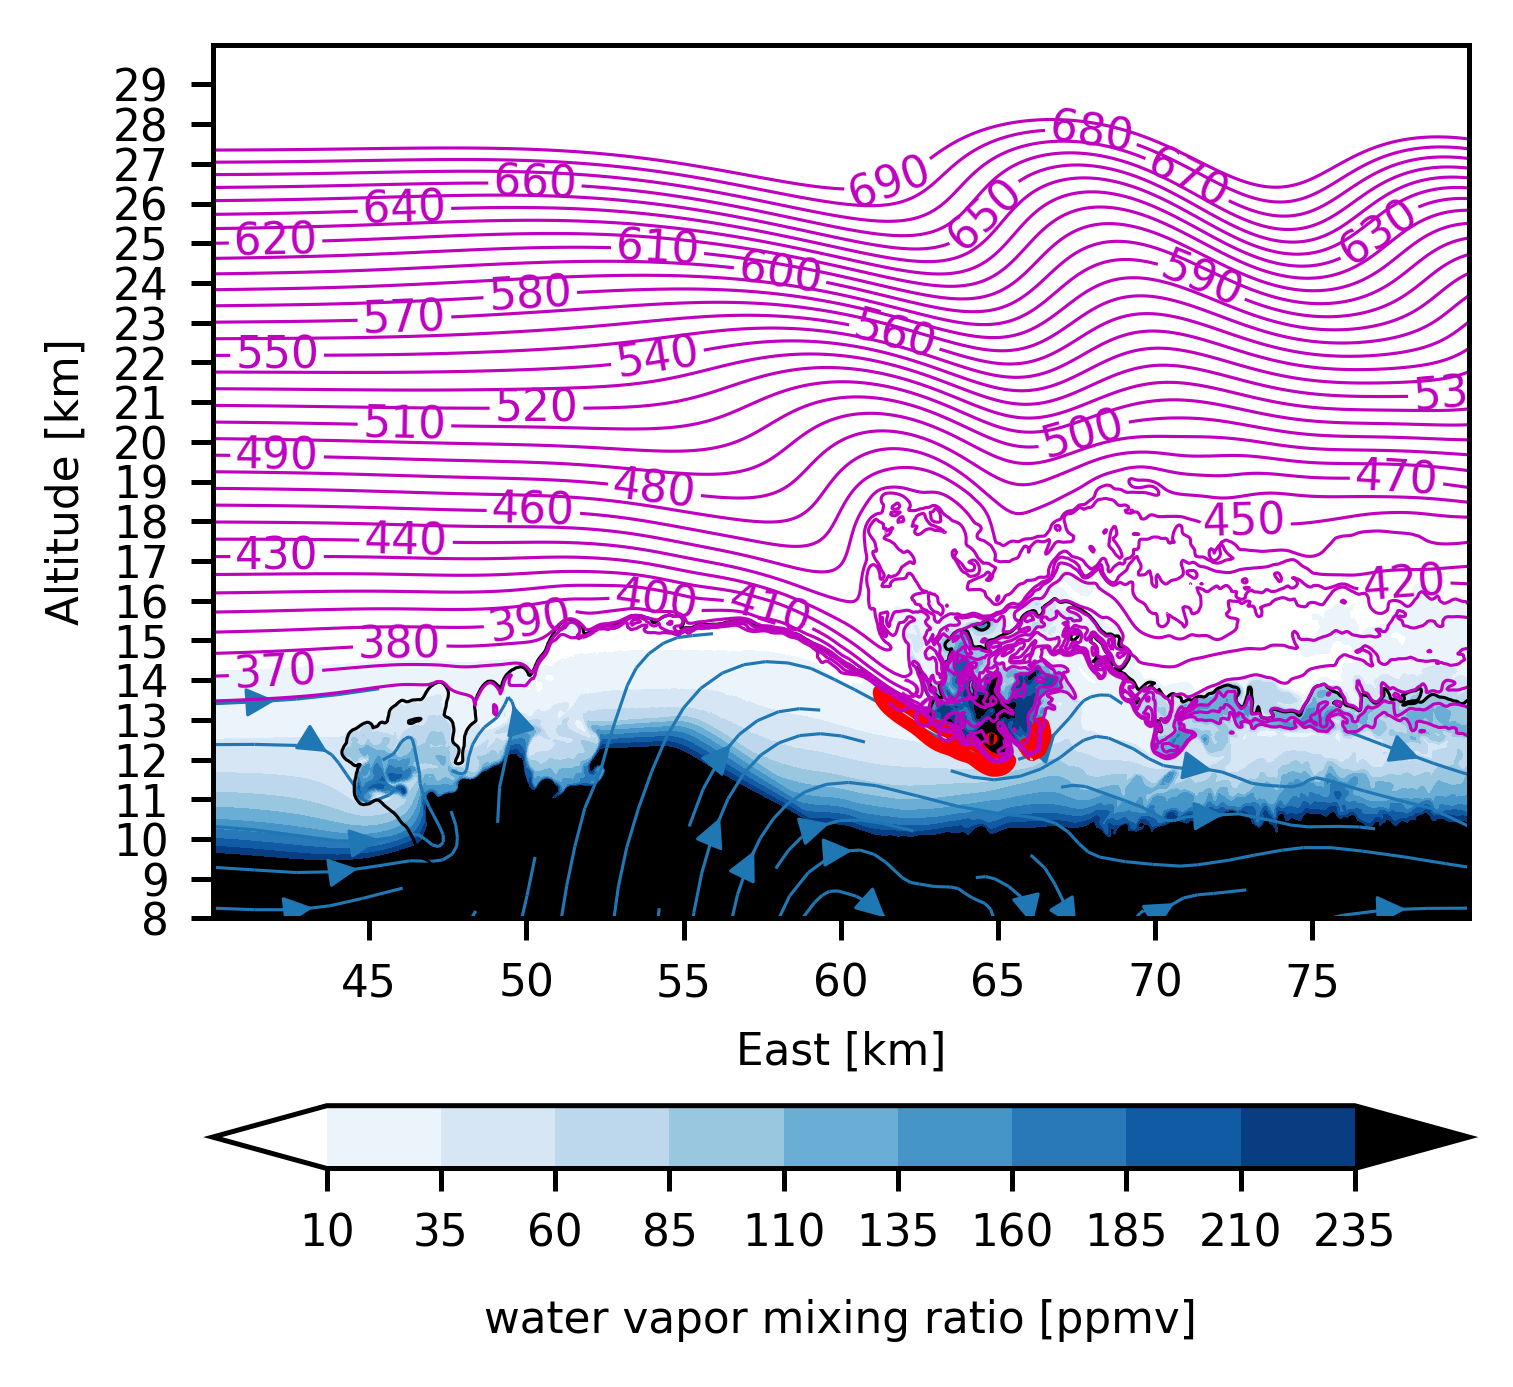

In [25]:
f, ax = plt.subplots(row,col,figsize = (9.15*cm,9.15*cm))
levels1 = [10 + 25*n for n in range(10)]
cm2.set_over((0., 0., 0.))
cm2.set_under((1., 1., 1.))
qvax = ax.contourf(x,z,qv*28.97/18.02*10**6,levels=levels1,cmap=cm2,extend='both')

#plot streamlines in-plane, only above 360 K surface
ax.streamplot(x,z,u*(theta<360),w*(theta<360),linewidth=0.5)

#plot windspeed contour
ax.contour(x,z,windspeed,[75],colors='r',linewidths=2)

#plot condensed cloud water mass mixing ratio
ax.contour(x,z,qc+qi+qg+qs,[5e-5],colors='k',linewidths=0.5)

# plot streamlines in-plane, only above 360 K surface
levels2 = np.arange(360,700,10)
cs = ax.contour(x,z,theta,levels=levels2,
             linewidths=0.5,colors='m')#[colors[ind]])
ax.clabel(cs,inline=1,fontsize=7,fmt='%.f')
        
ax.set_ylabel('Altitude [km]',fontsize=7)
        
ax.set_xlabel('East [km]',fontsize=7)
ax.yaxis.set_ticks(range(8,30))
ax.tick_params(axis='x',labelsize=7)
ax.tick_params(axis='y',labelsize=7)

cbar = f.colorbar(qvax,ax=ax,
        boundaries = levels1,
        extendfrac='auto',orientation='horizontal')
        #spacing='proportional'
        #orientation='horizontal'
cbar.set_label("water vapor mixing ratio [ppmv]",fontsize=7,labelpad=+7)
cbar.ax.tick_params(labelsize=7)

ax.set_ylim([8,30])
# ax.set_title('Stratospheric Gravity Waves at Minute 50')
f.savefig('final_figures/high_alt_gravity_waves.jpeg')

In [27]:
def get_stream_segments(streamlines):
    starts = np.array([i.vertices[0] for i in streamlines.lines.get_paths()])
    ends = np.array([i.vertices[1] for i in streamlines.lines.get_paths()])

    streamXsegments = [[starts[0,0]]]
    streamYsegments = [[starts[0,1]]]

    i = 1
    while i < len(starts):
        next_start = starts[i,0]
        if next_start == ends[i-1,0]:
            streamXsegments[-1].append(next_start)
            streamYsegments[-1].append(starts[i,1])
        else:
            streamXsegments.append([next_start])
            streamYsegments.append([starts[i,1]])
        i += 1
    
    print(f'number of segments: {len(streamXsegments)}')
    return [np.array(i) for i in streamXsegments], [np.array(i) for i in streamYsegments]

def get_smith_parameters(streamYsegments, upper_stream_idx, lower_stream_idx, turbulent_start_x):
    l = 0.647379
    
    lower_stream_matched_idx = match_parcels_by_x(
        streamXsegments[upper_stream_idx][:turbulent_start_x],
        streamXsegments[lower_stream_idx]
    )
#     print(streamYsegments[lower_stream_idx])
#     print(f'lower_stream_matched_idx: {lower_stream_matched_idx}')
    lower_stream_matched_Y = streamYsegments[lower_stream_idx][lower_stream_matched_idx]
    
    deflection = (streamYsegments[upper_stream_idx][:turbulent_start_x] - streamYsegments[upper_stream_idx][0])*l
    h = (lower_stream_matched_Y - lower_stream_matched_Y[0]) * l
    plt.plot(h, deflection)
    plt.xlim([-2, 2])
    plt.ylim([-3, 1])
    return deflection, h

def match_parcels_by_x(parcel_one, parcel_two):
        # Takes x-data for two parcels, the first already truncated before turbulent mixing
        # returns an indexer for parcel_two that aligns on x with parcel_one
        x_matched_two_index = []
        for x in parcel_one:
            x_matched_two_index.append(_get_left_x_index(parcel_two, x))
        return x_matched_two_index
    
def _get_left_x_index(x_data, x_value):
    # only use this on one-to-one chunks of parcel paths
    candidates = x_data[x_data <= x_value]
    # POTENTIAL REFINEMENT: look on either side cuz some of these are far behind but really close ahead
    if (not np.any(candidates)) or (abs(x_value - candidates.max()) > 2): # if no x less than value or closest is far
#         print(x_value)
#         print(candidates)
        return None
    return len(candidates) - 1


streamXsegments, streamYsegments = get_stream_segments(streamlines)

number of segments: 224


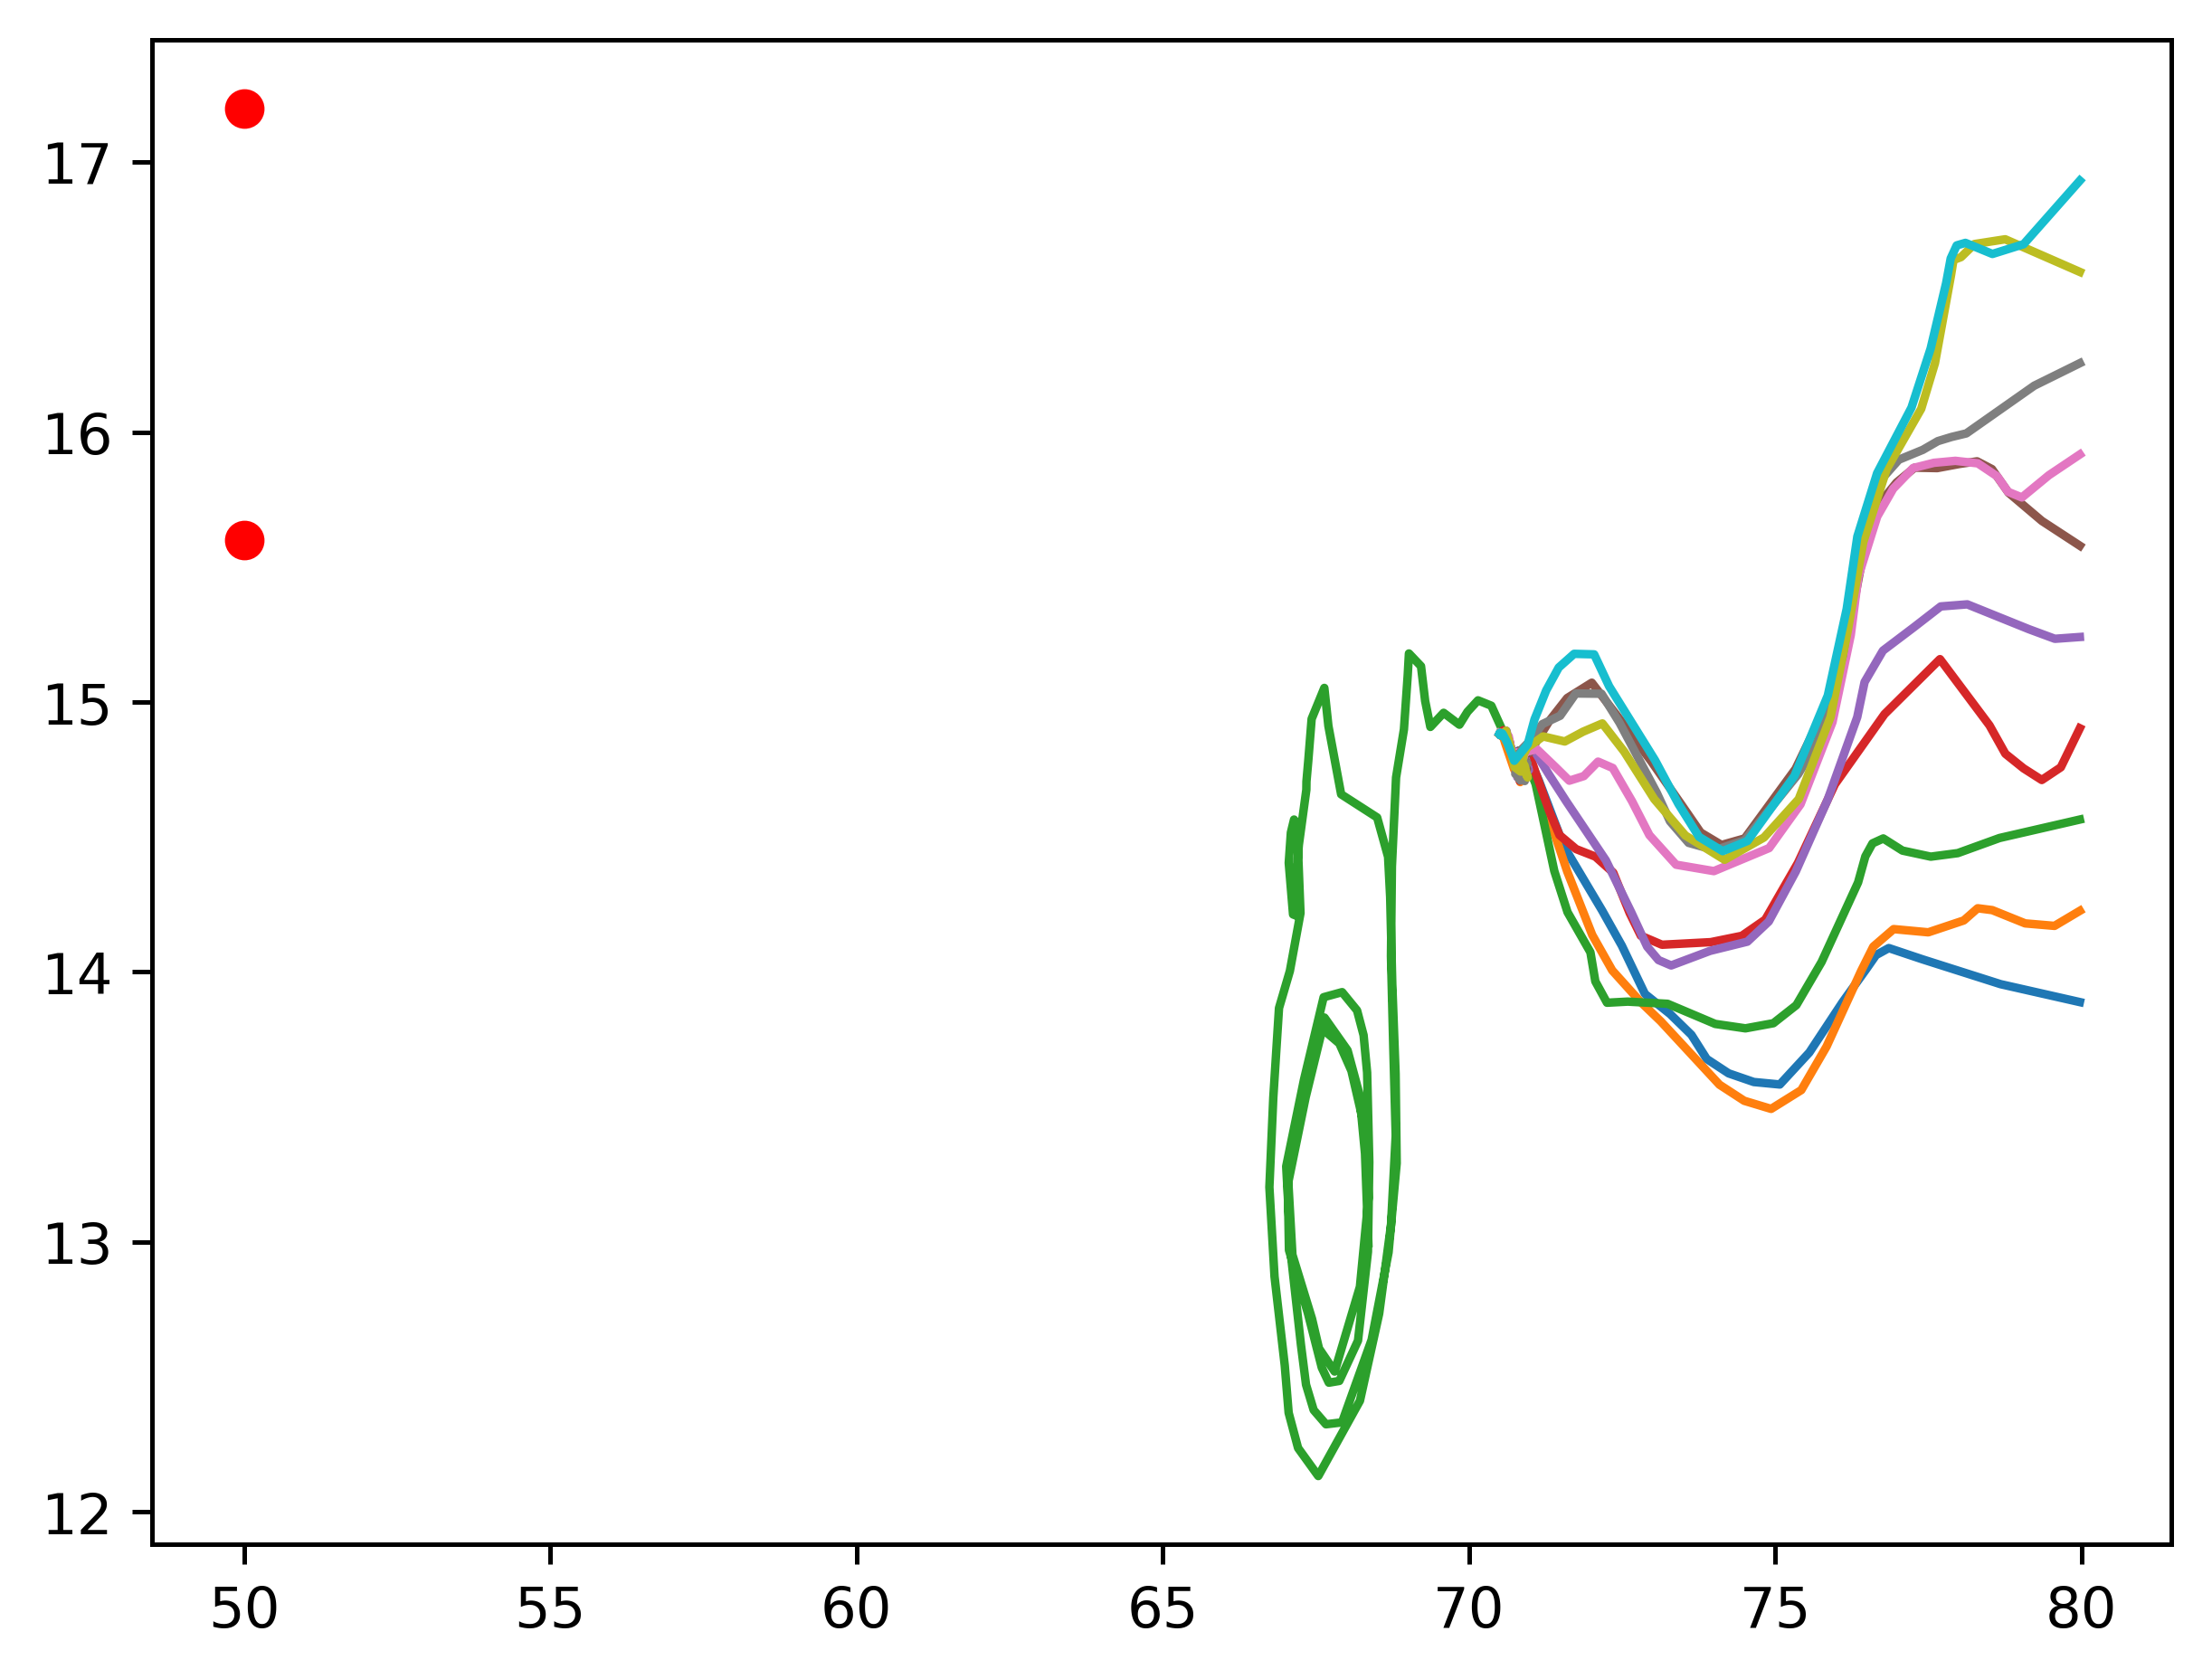

In [28]:
for i in range(45,55):
    plt.plot(streamXsegments[i], streamYsegments[i])
plt.scatter([50, 50], [15.6, 17.2], color='r')

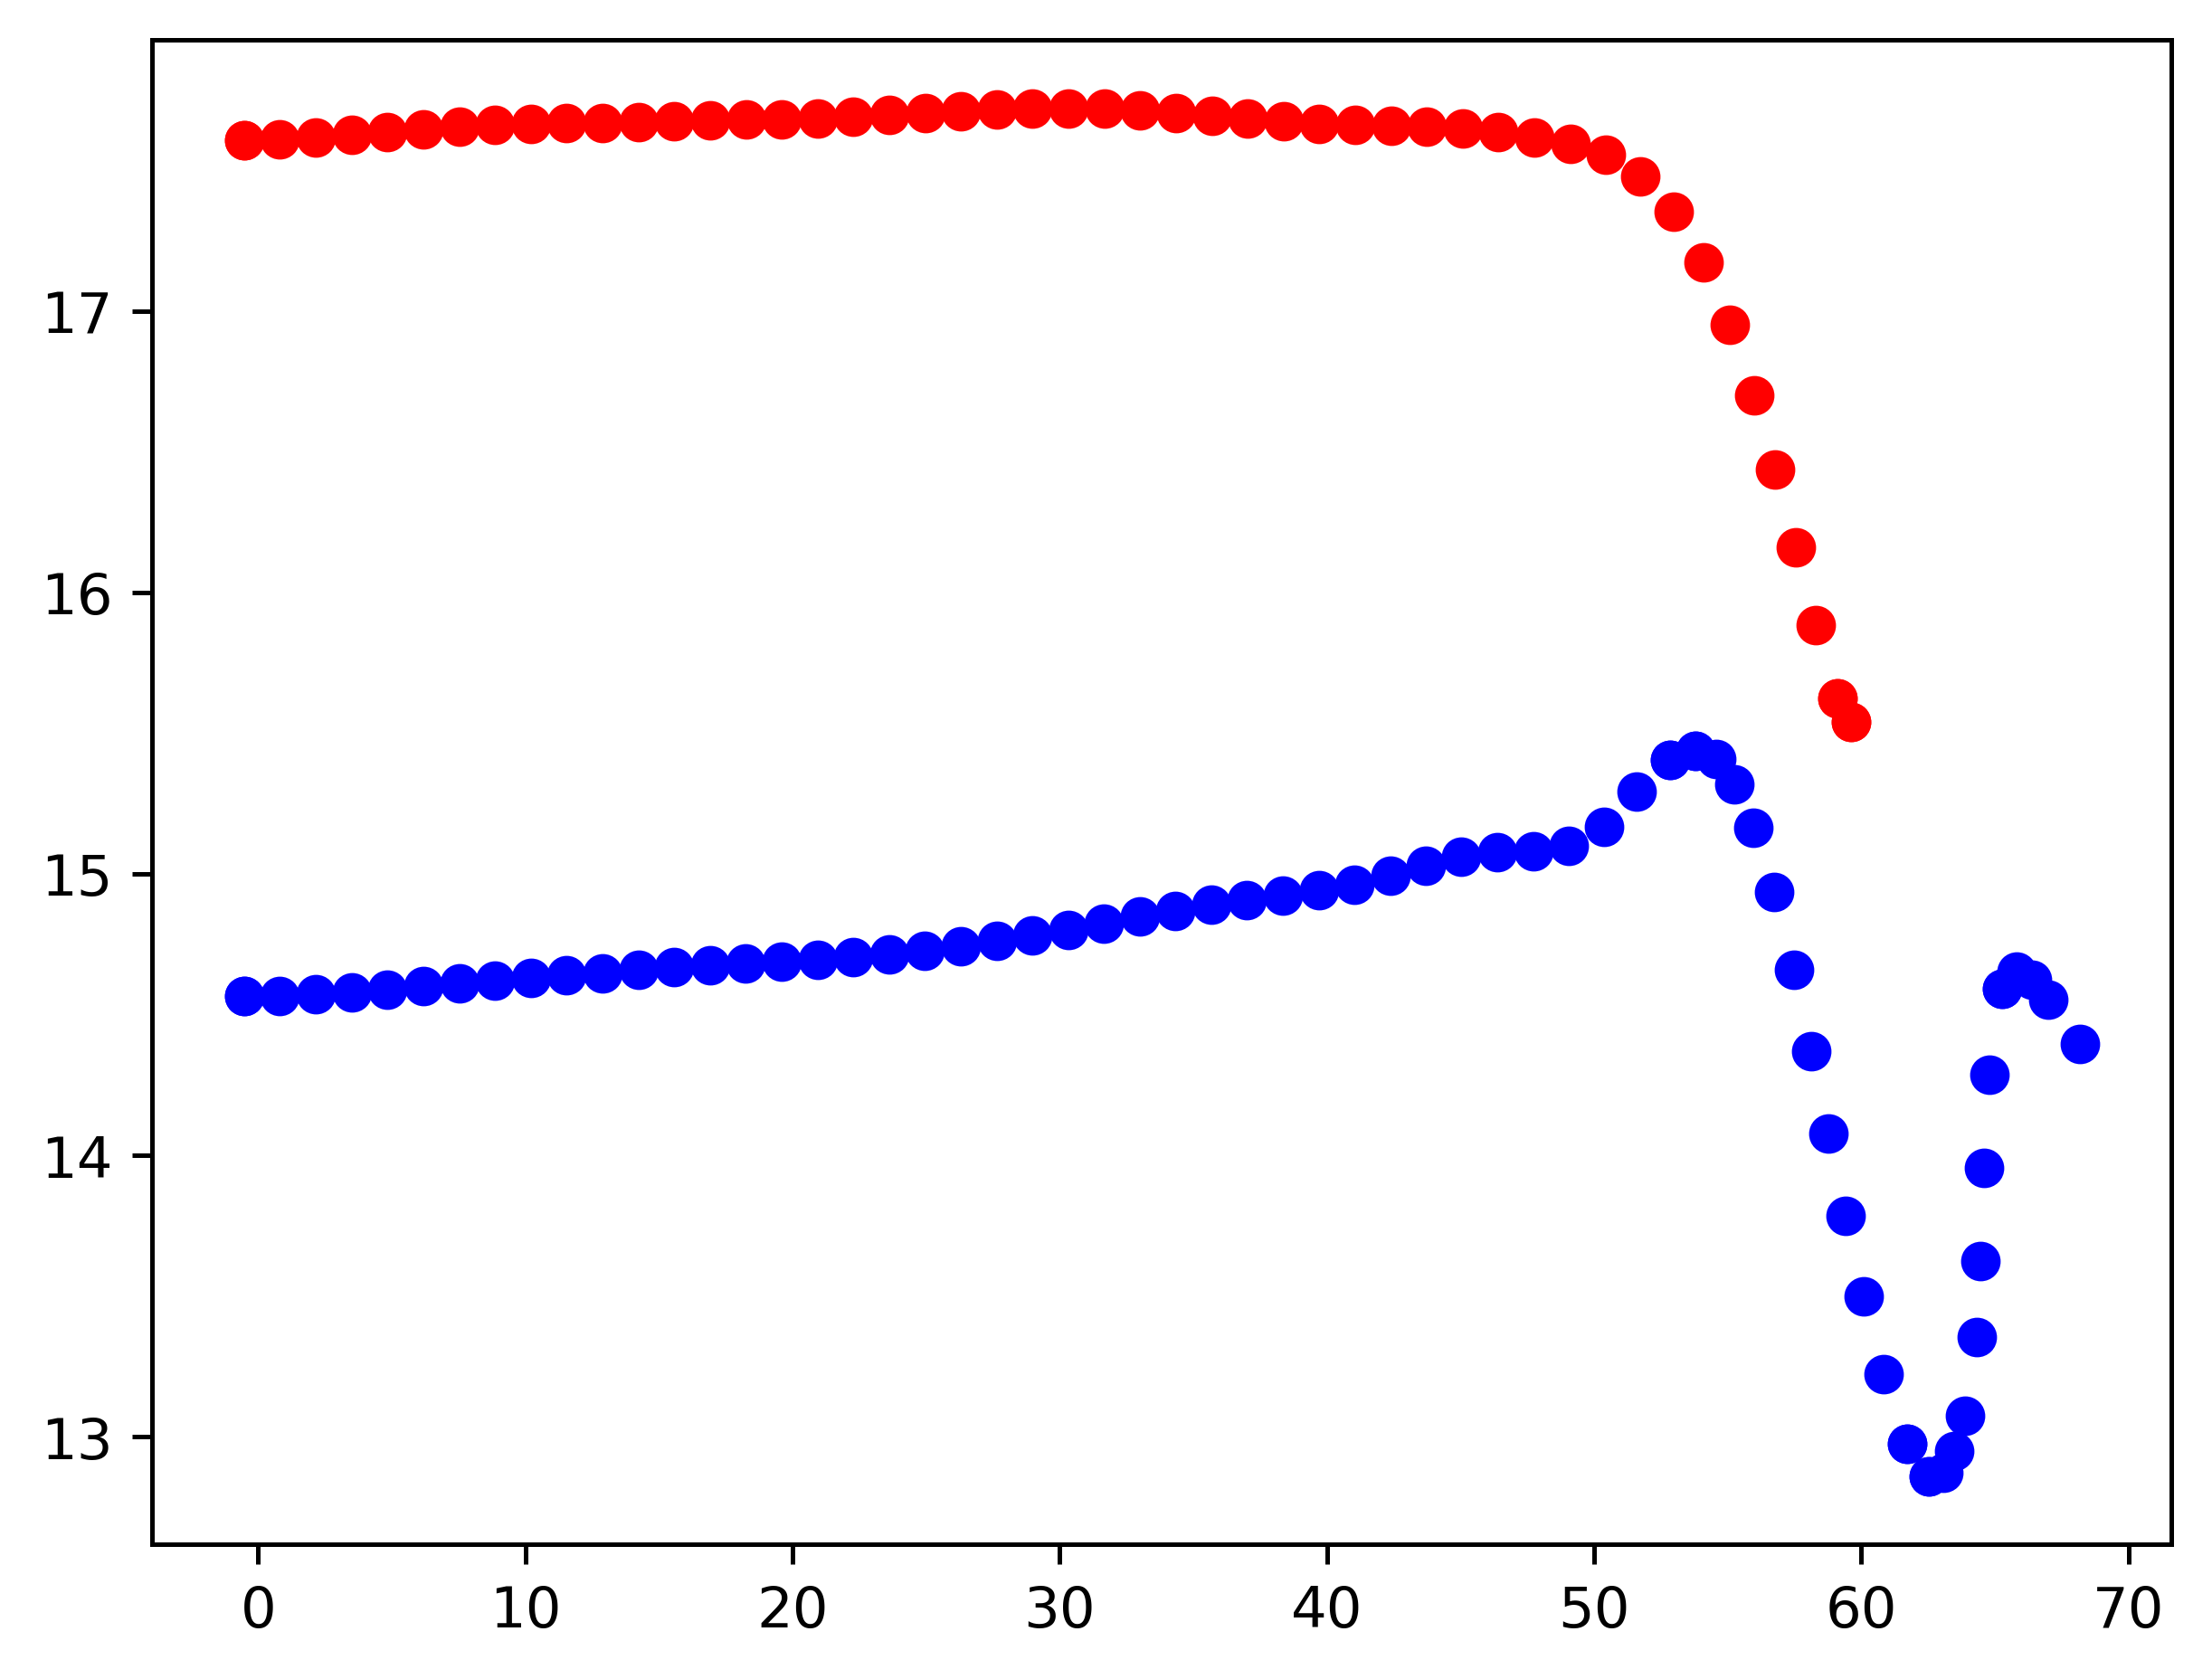

In [172]:
turbulent_start_x = 52
plt.scatter(streamXsegments[46][:turbulent_start_x], streamYsegments[46][:turbulent_start_x], color='r')
plt.scatter(streamXsegments[53][:turbulent_start_x + 20], streamYsegments[53][:turbulent_start_x + 20], color='b')

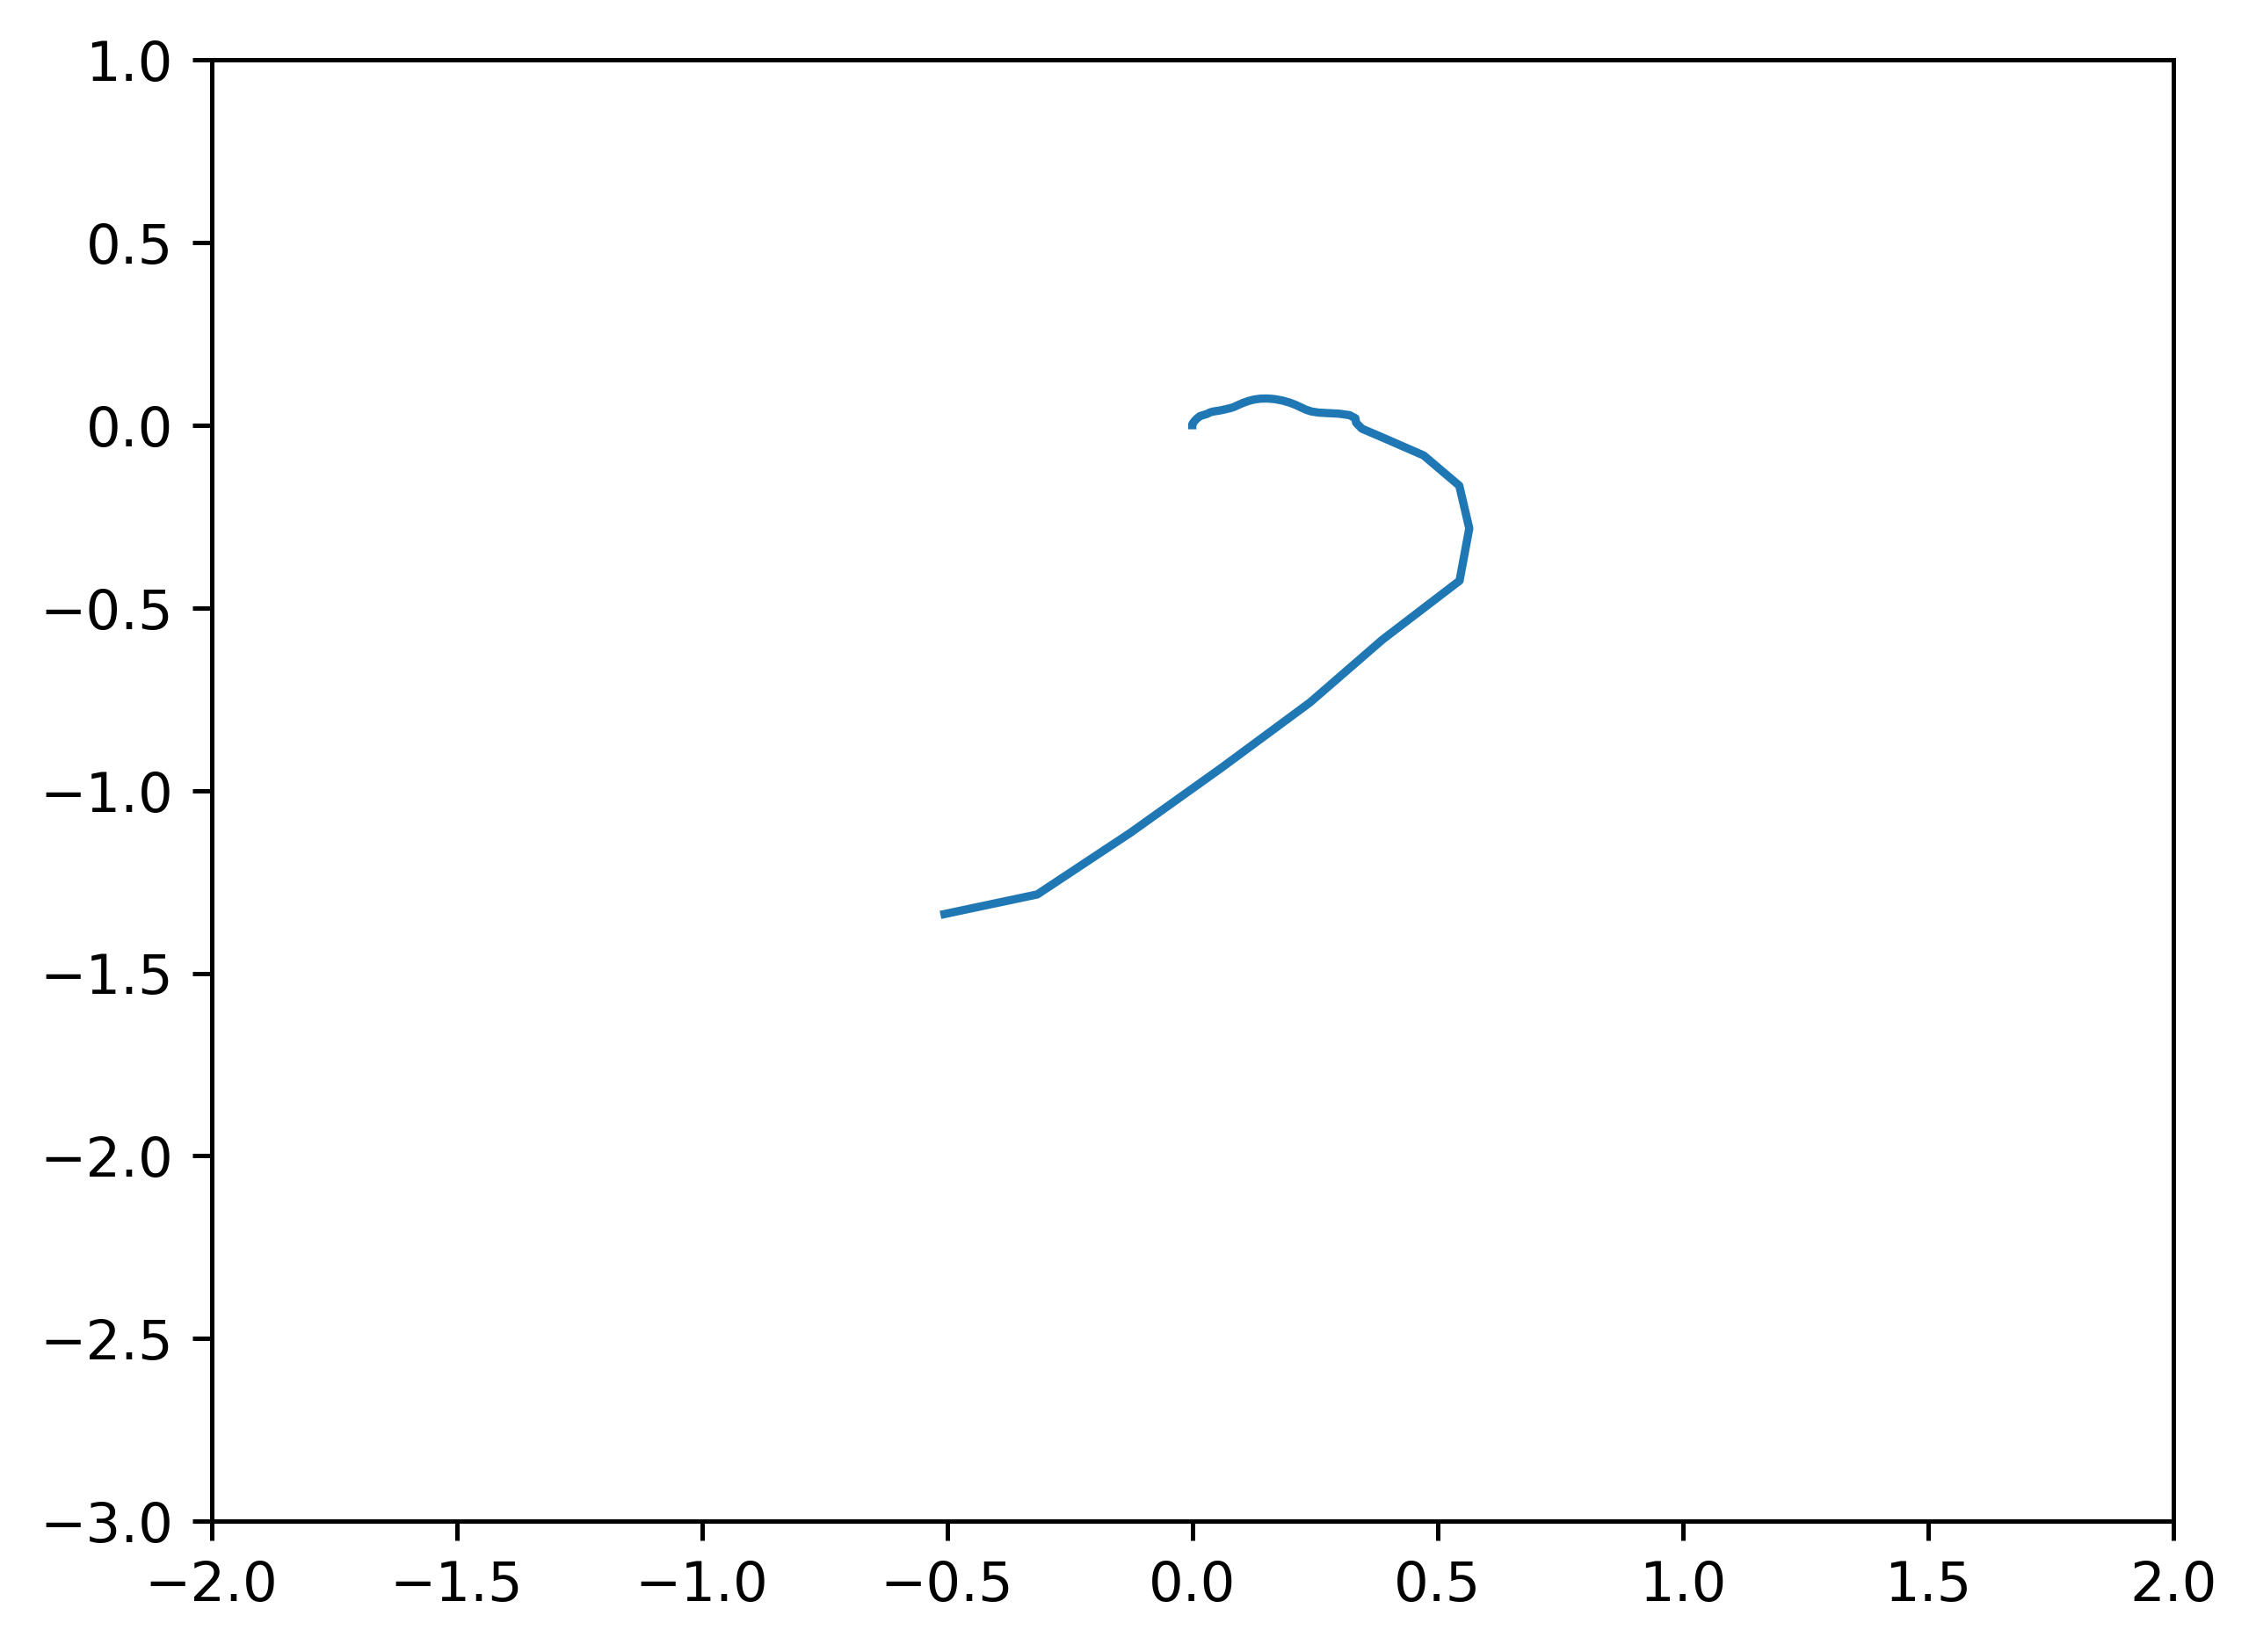

In [8]:
deflections[2400] = get_smith_parameters(streamYsegments, 46, 53, turbulent_start_x=52)

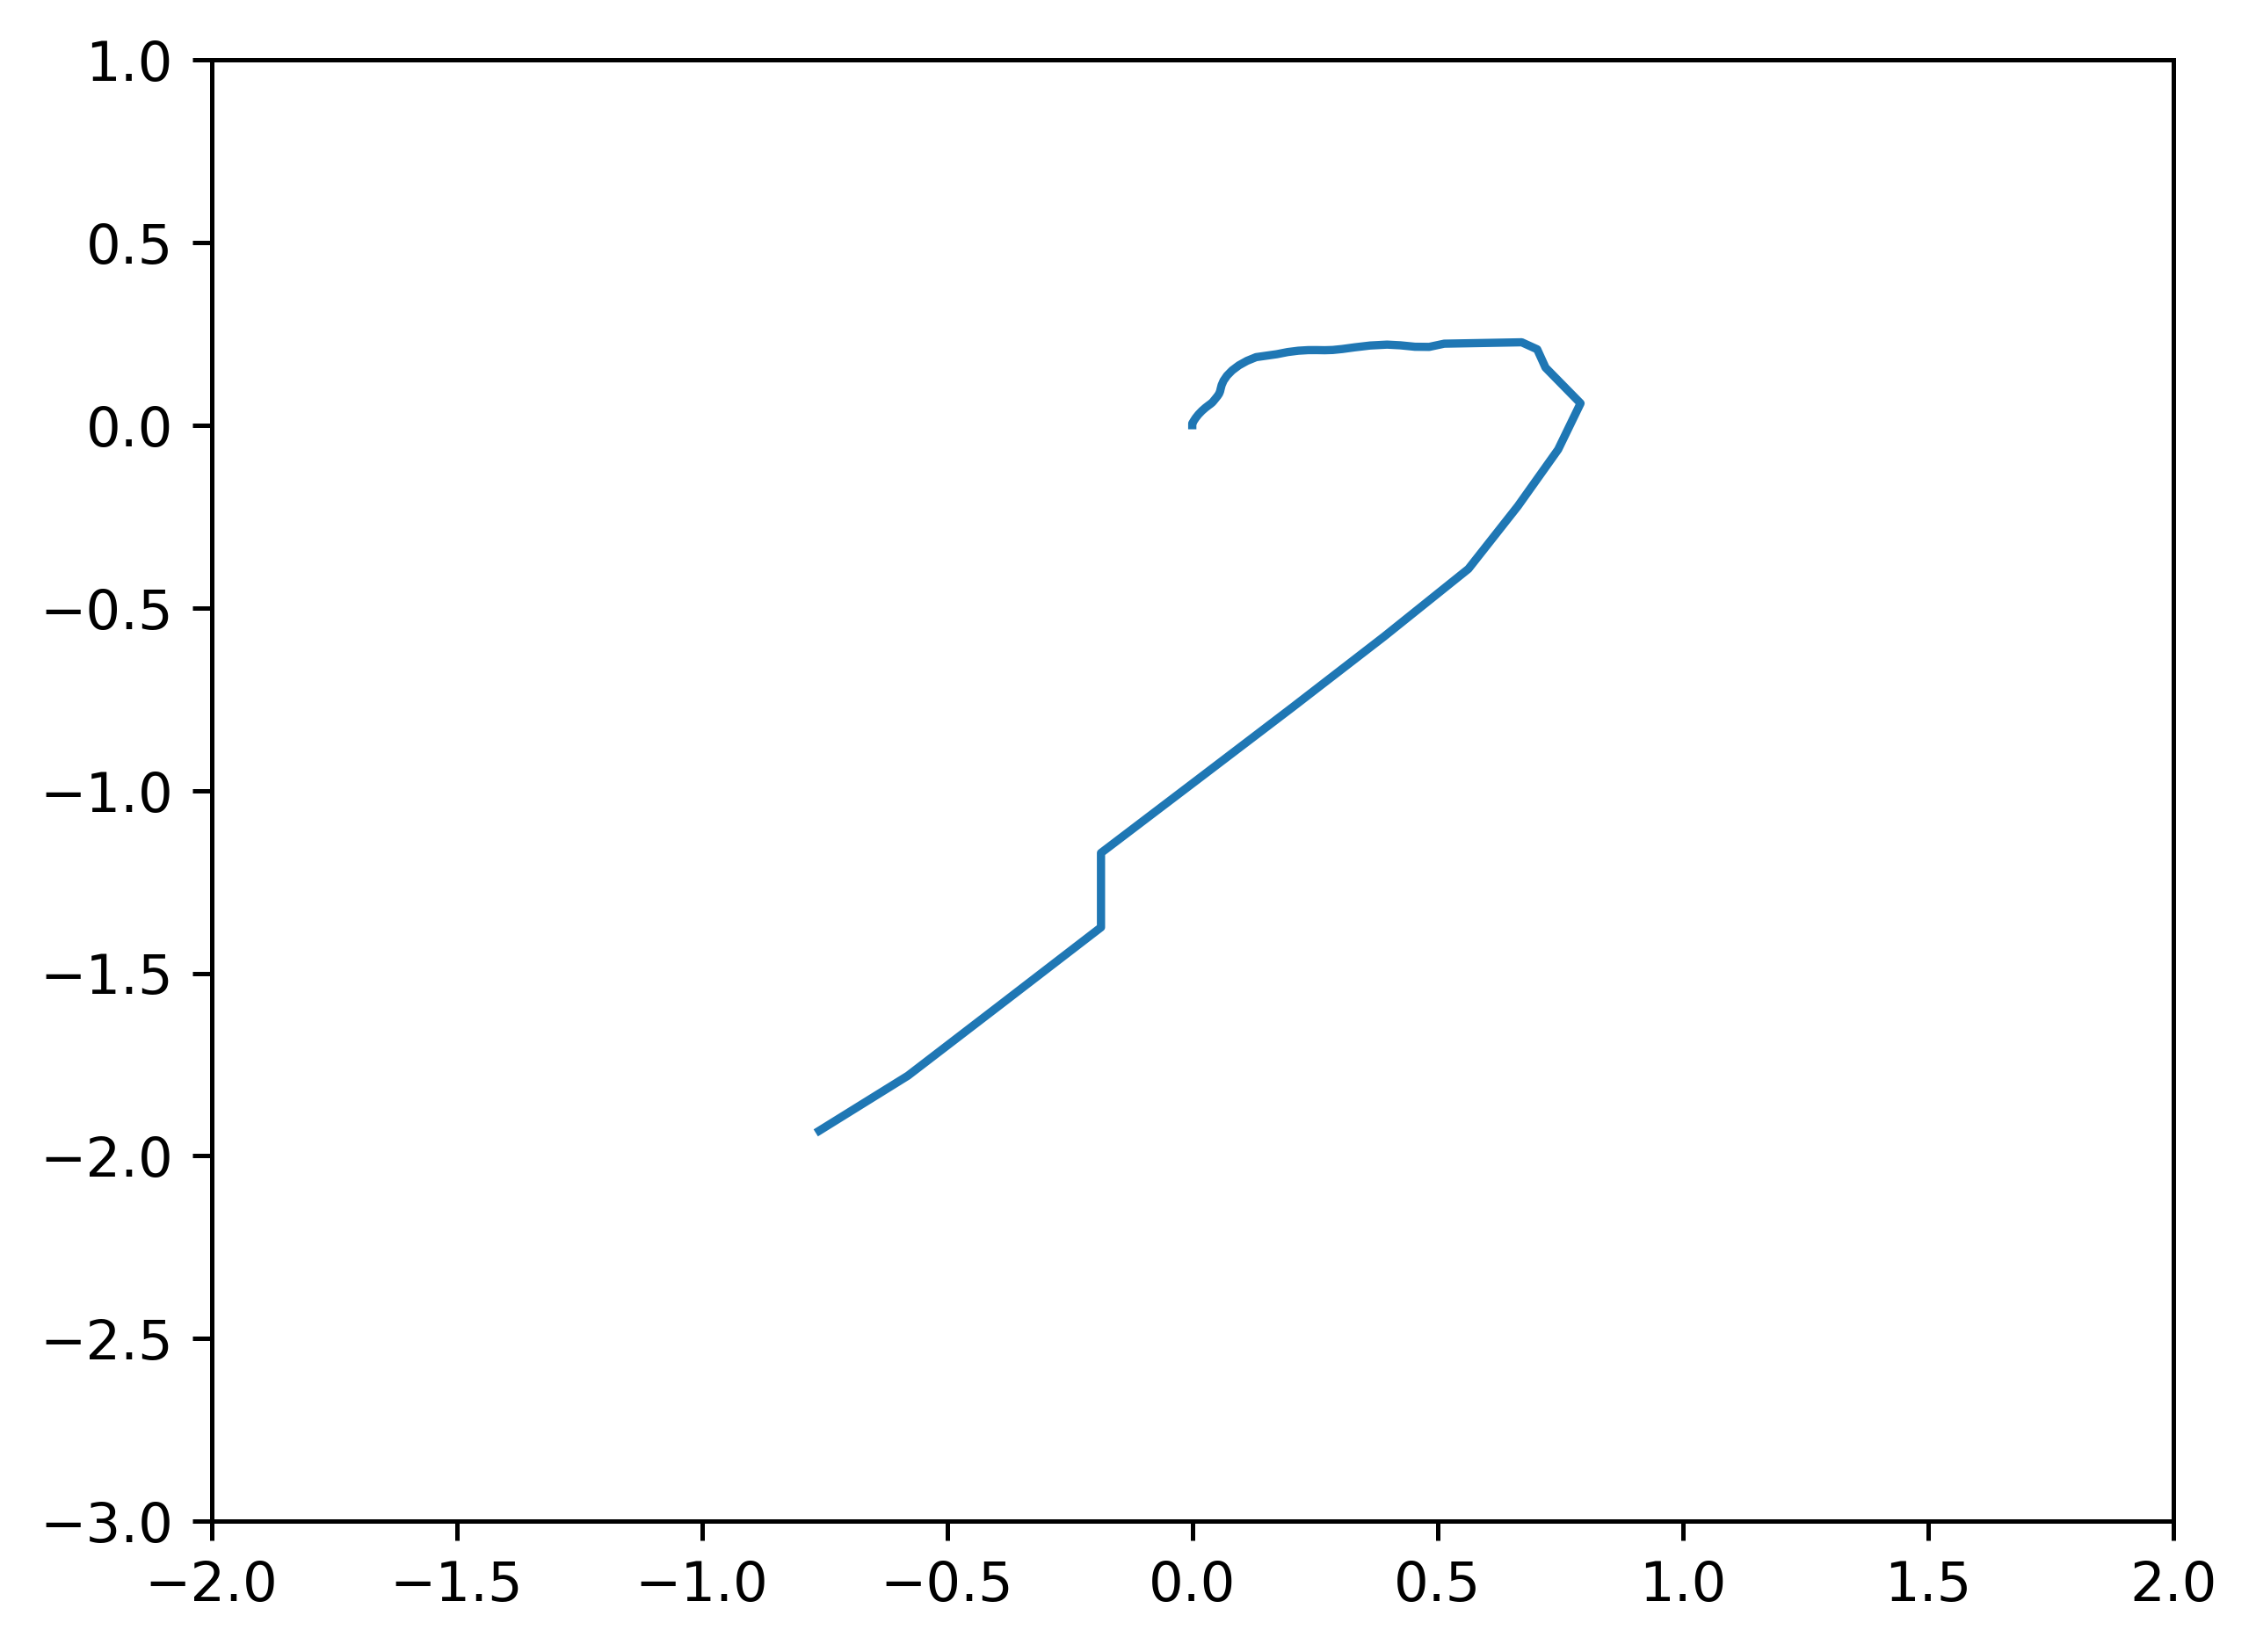

In [13]:
deflections[2700] = get_smith_parameters(streamYsegments, 41, 47, turbulent_start_x=57)

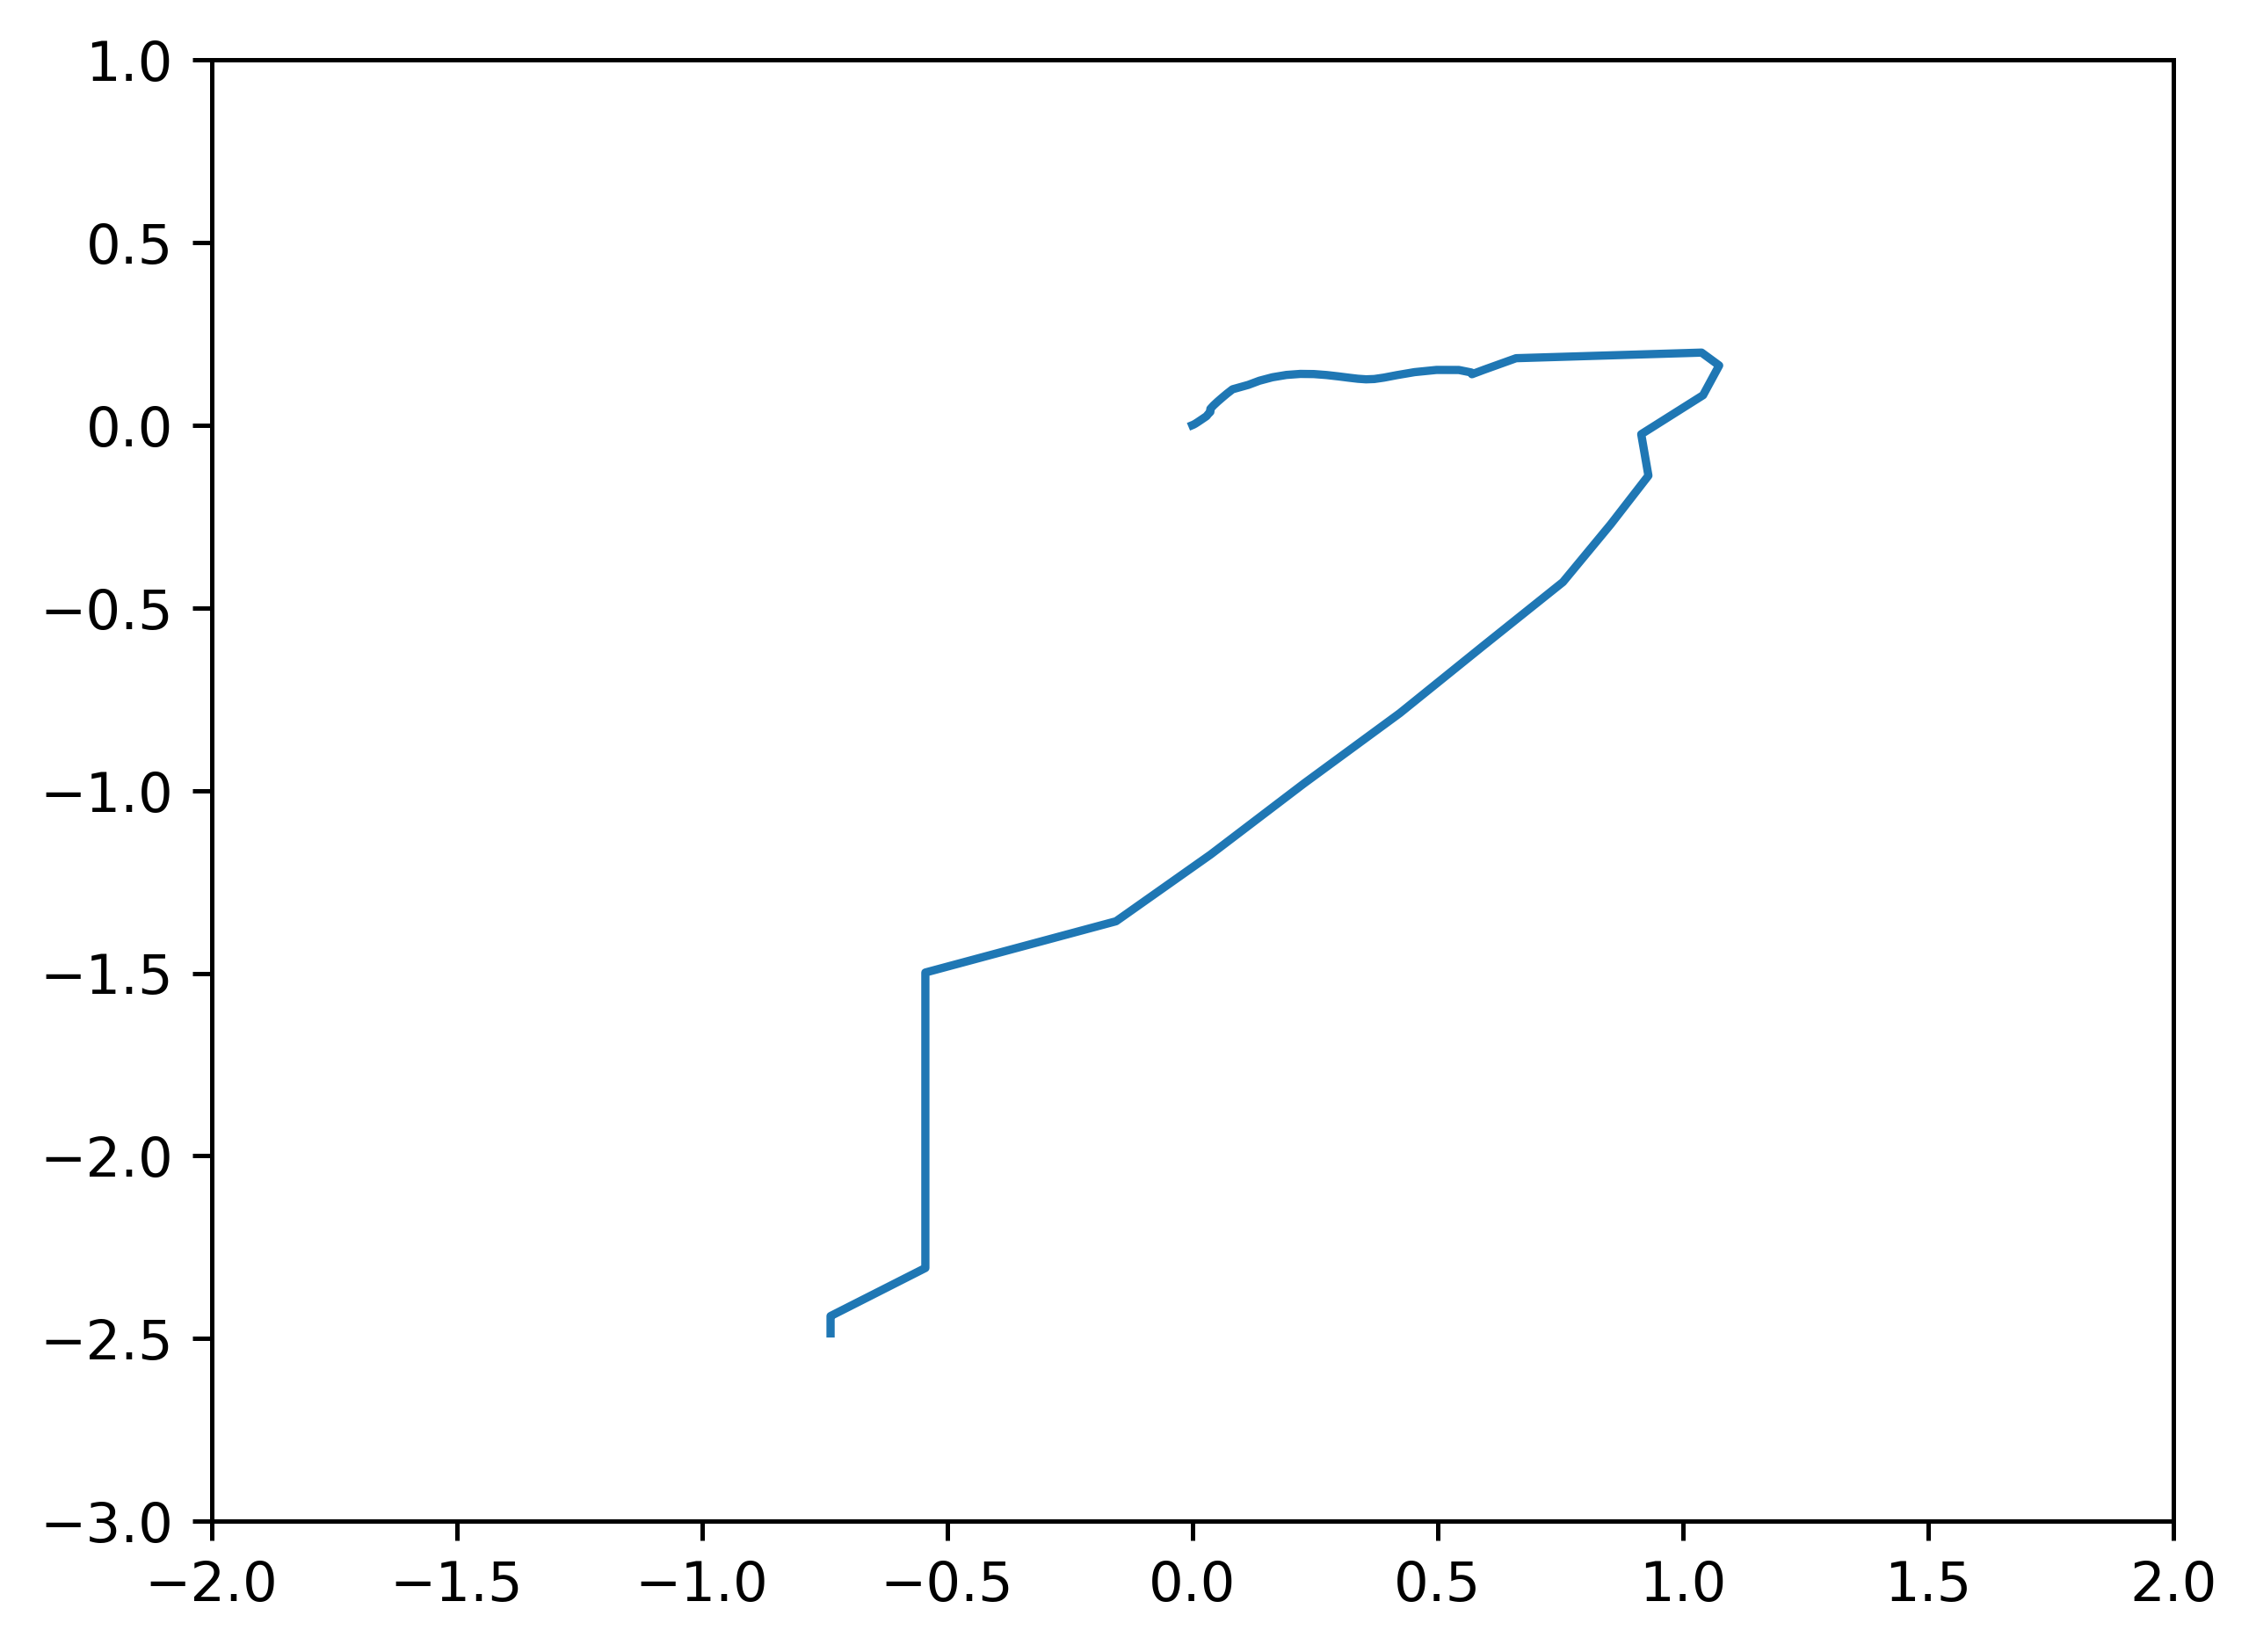

In [18]:
deflections[3000] = get_smith_parameters(streamYsegments, 52, 60, turbulent_start_x=80)

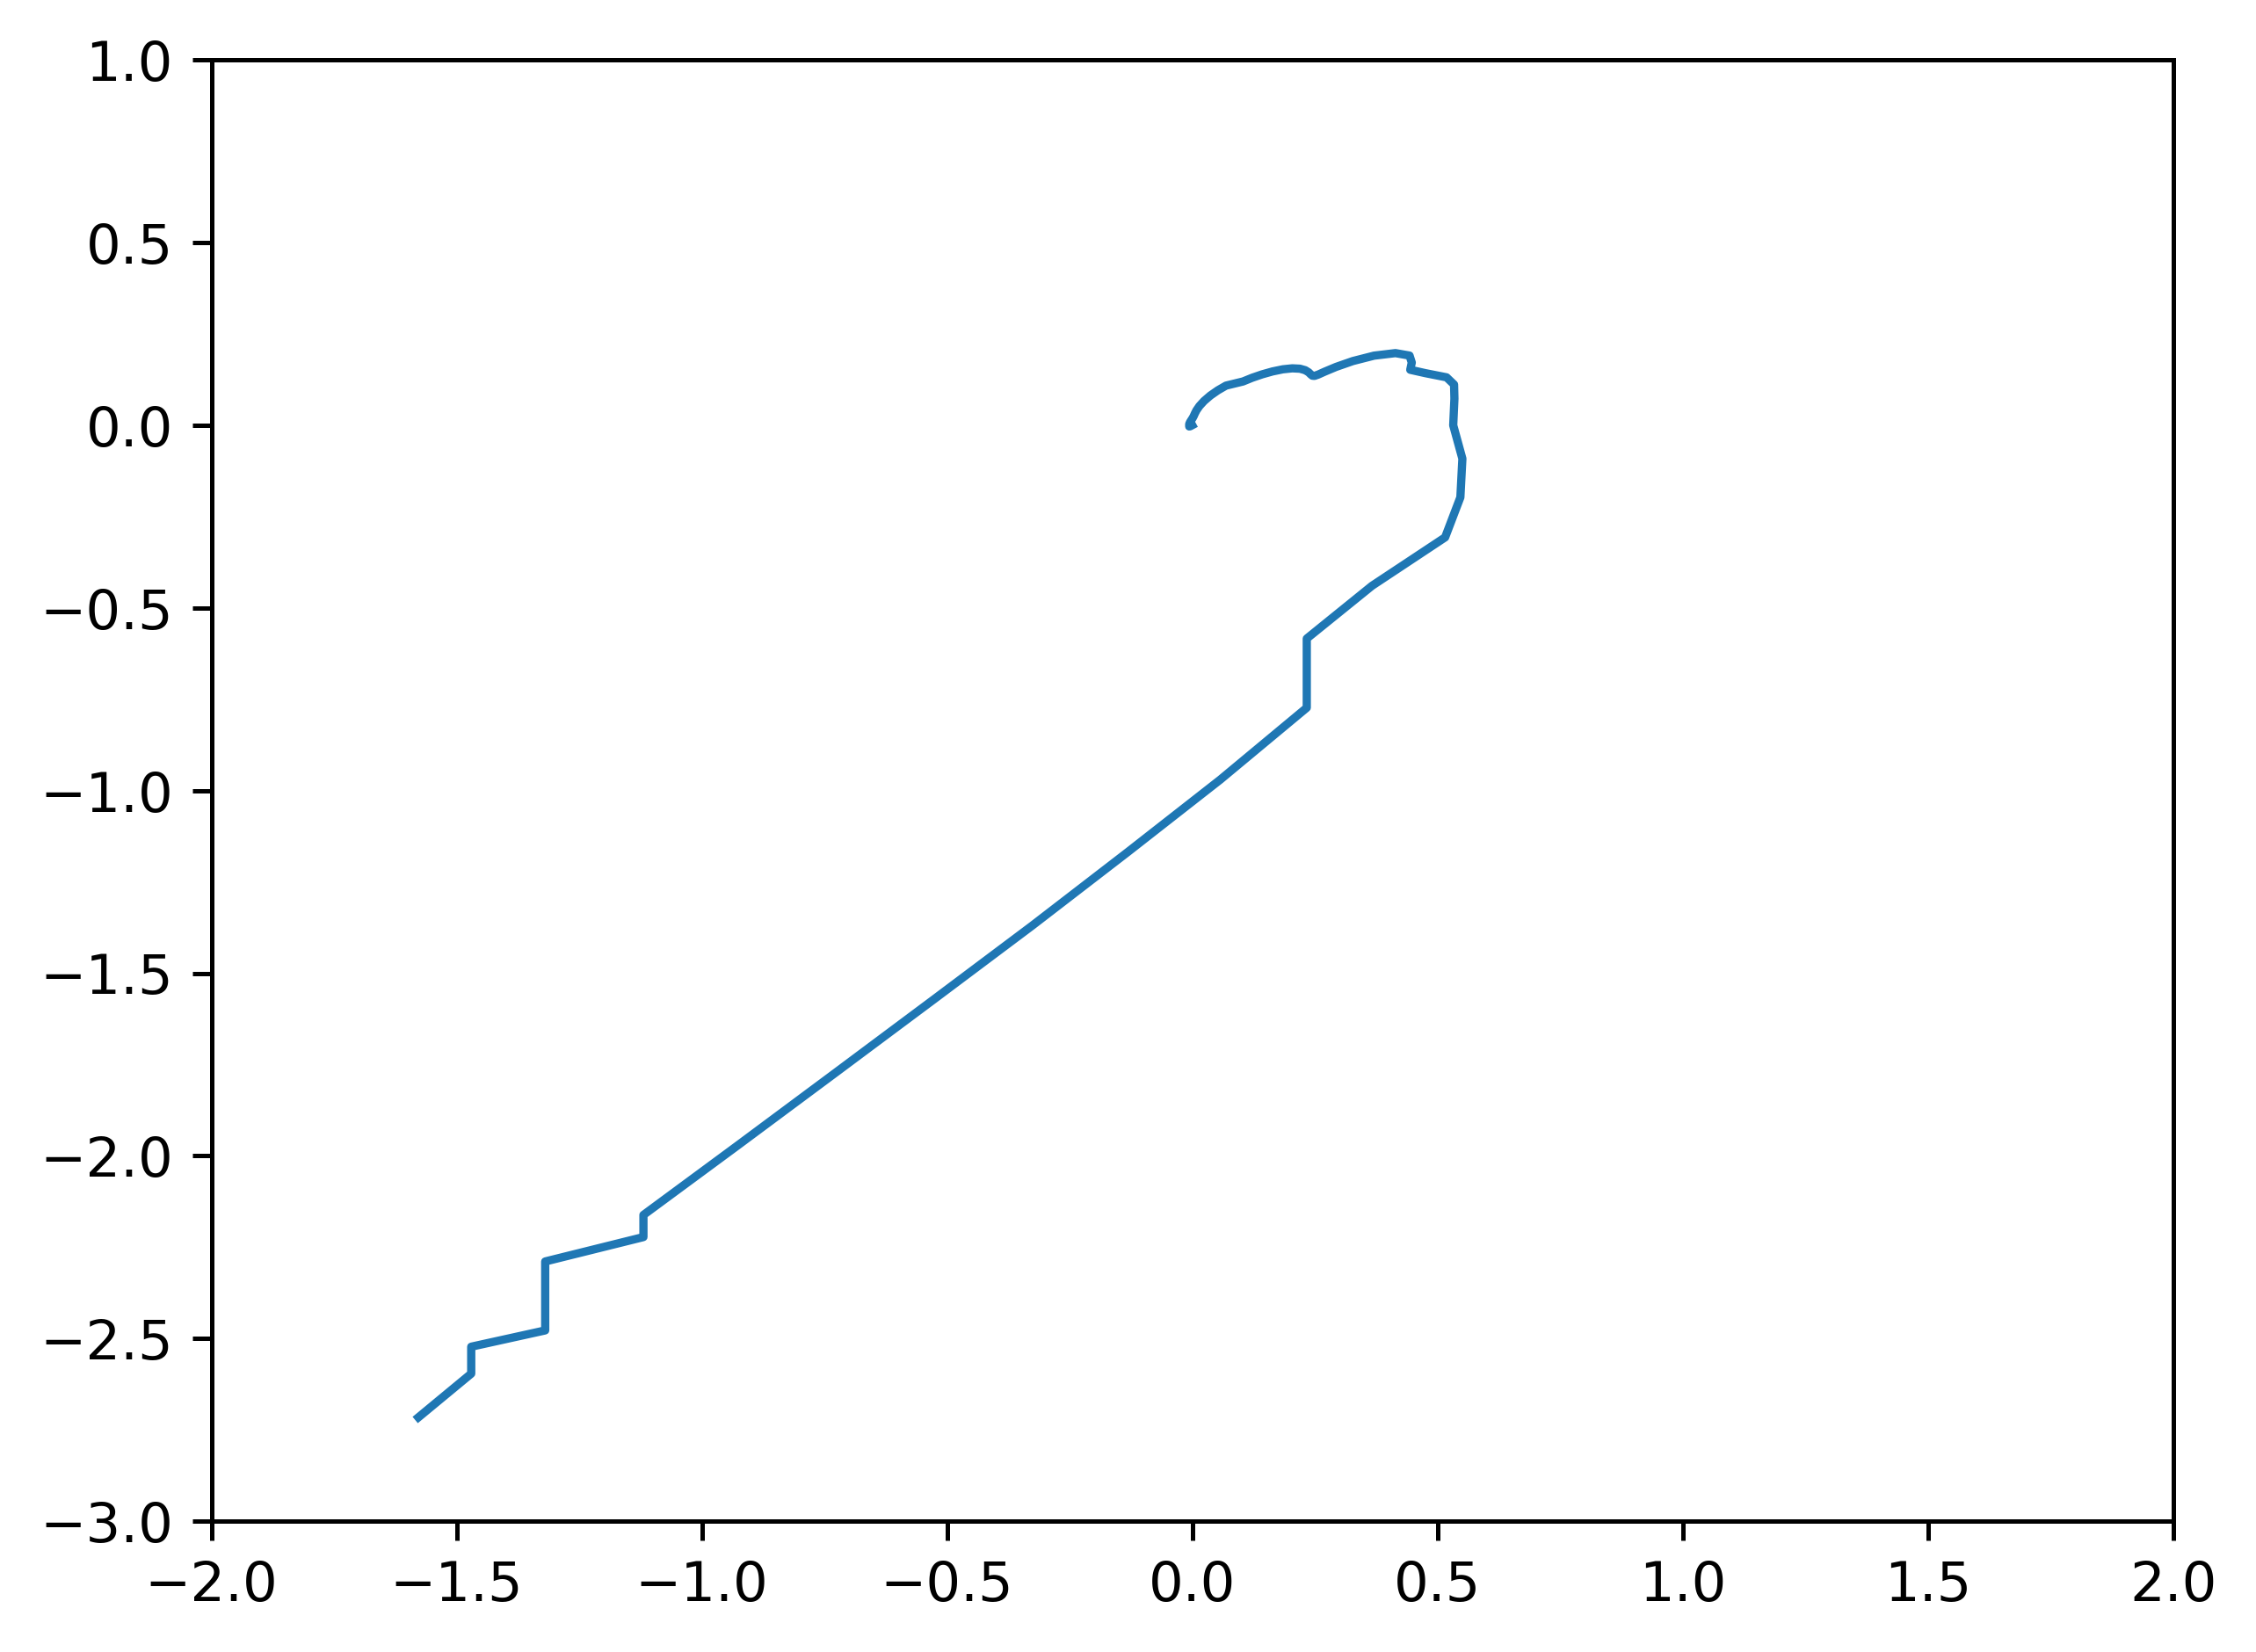

In [23]:
deflections[3300] = get_smith_parameters(streamYsegments, 70, 74, turbulent_start_x=70)

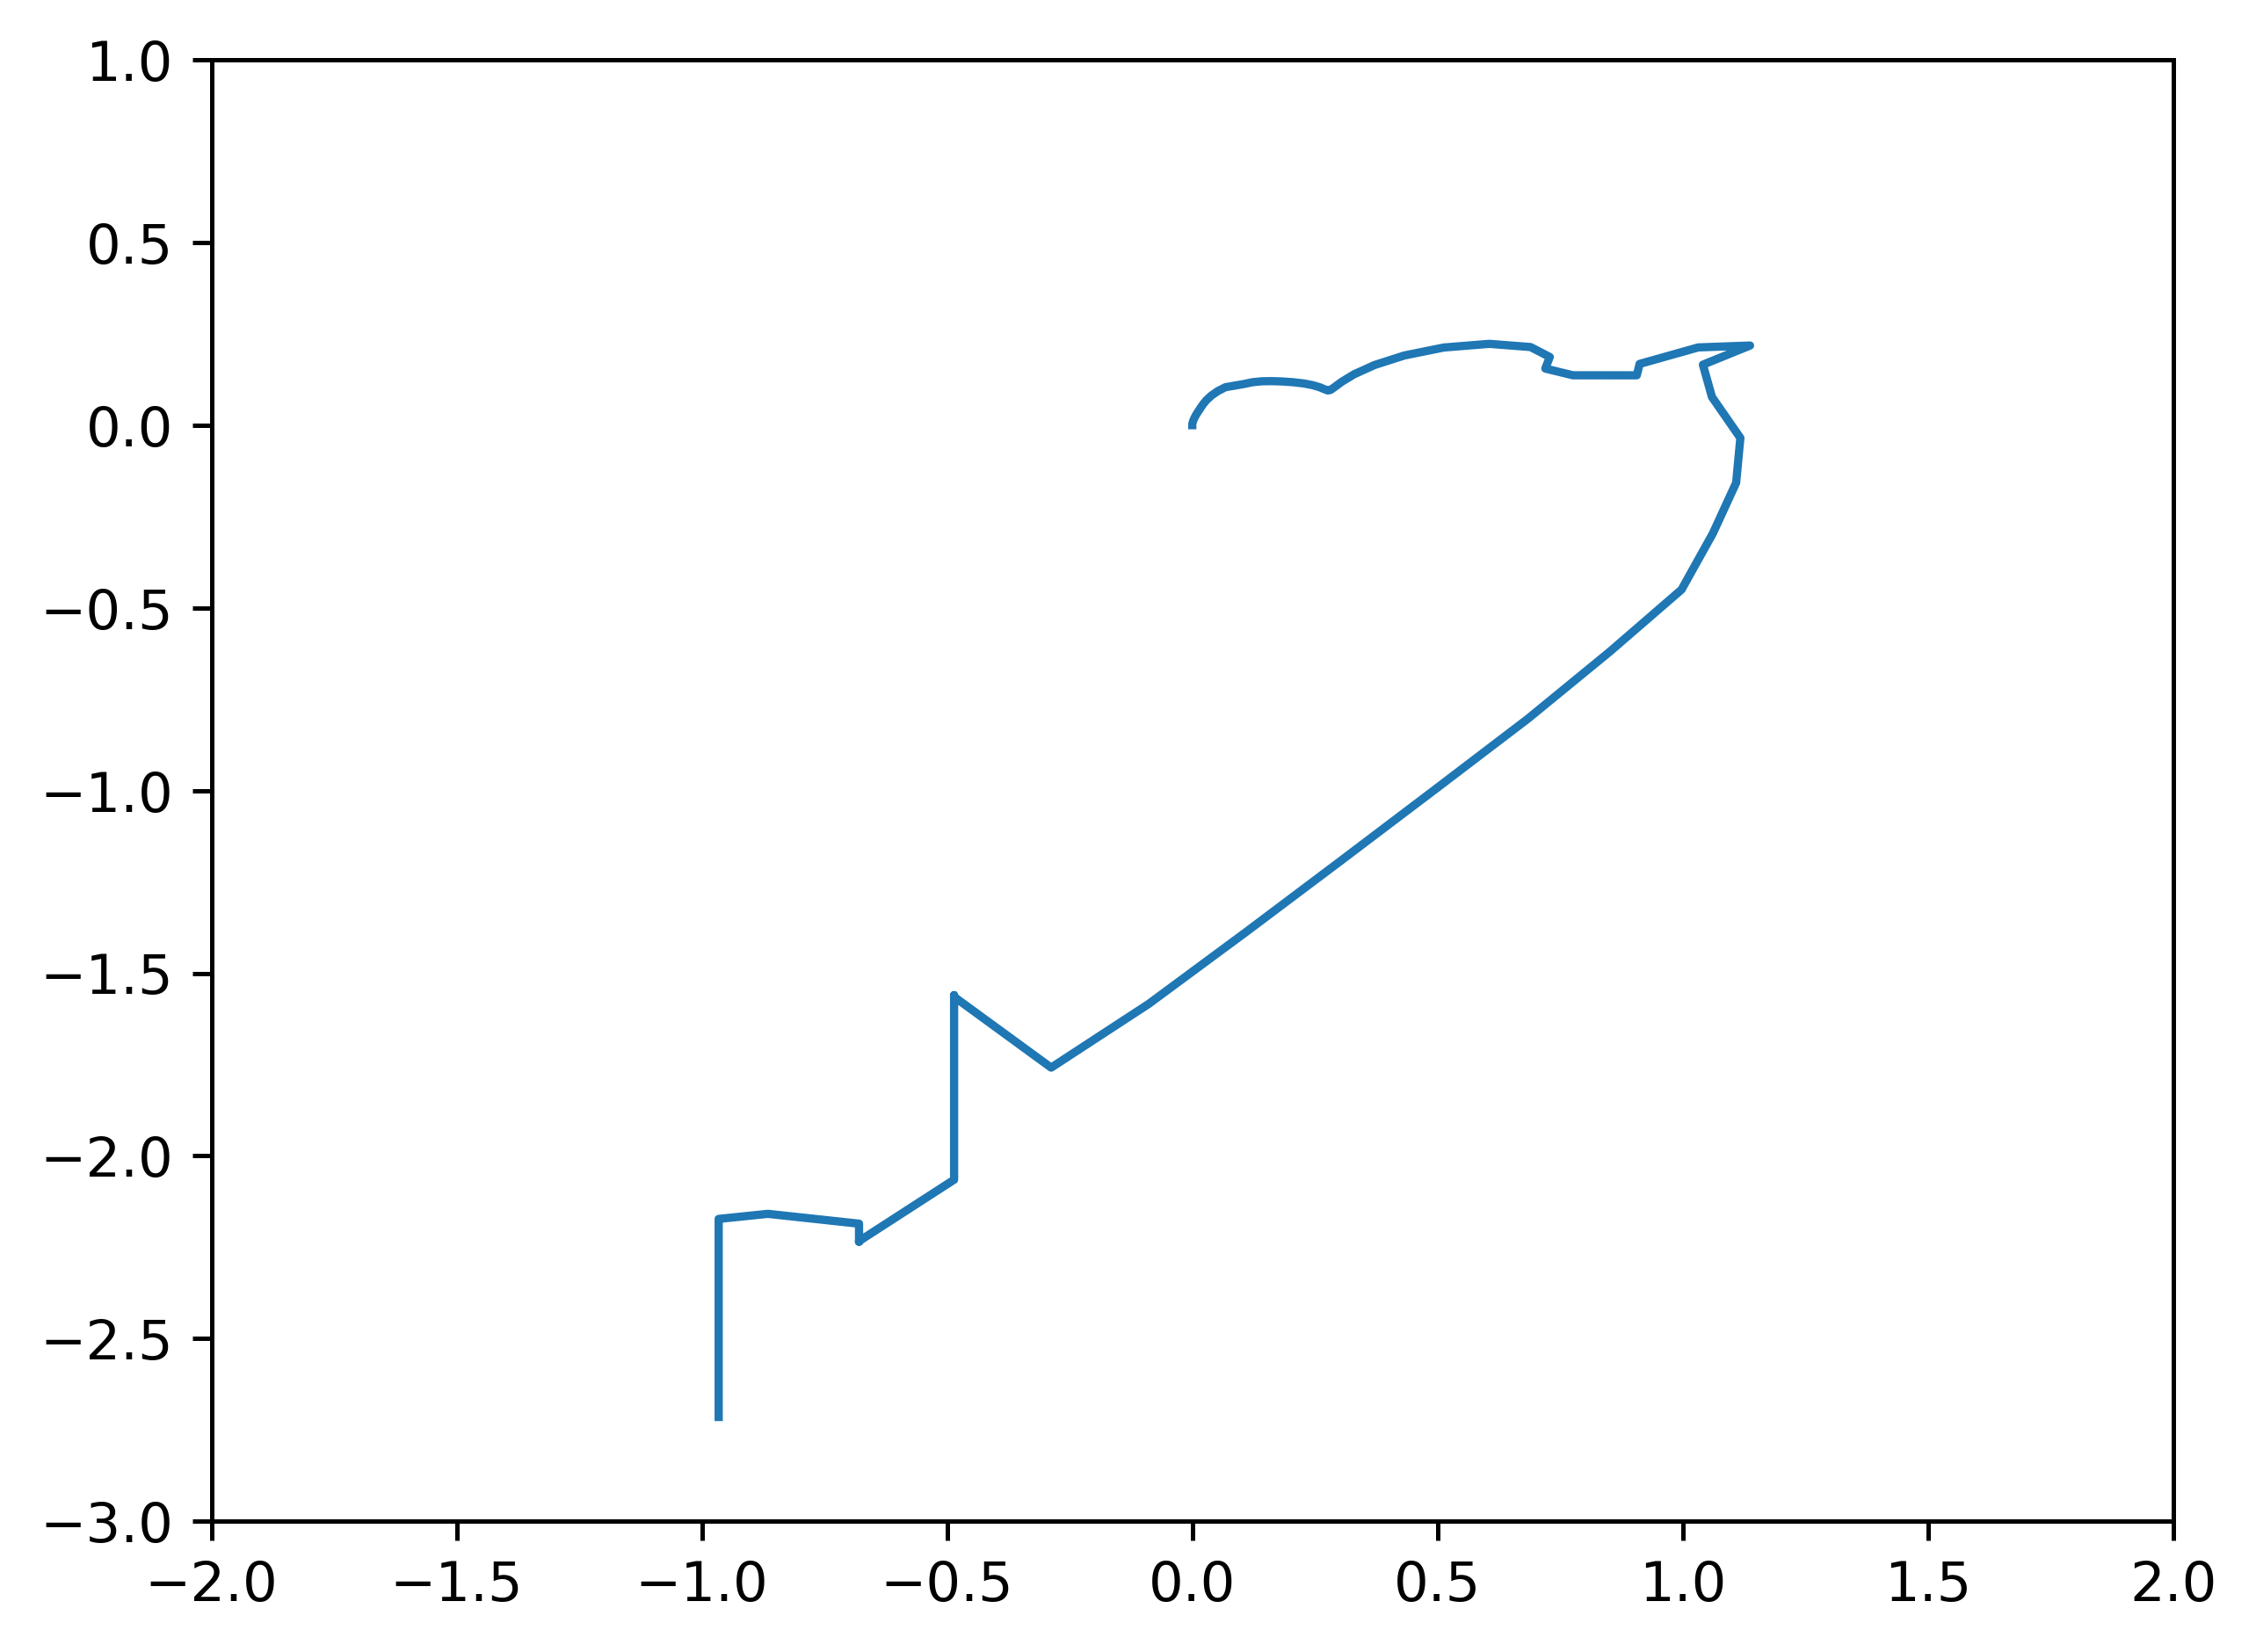

In [29]:
deflections[3600] = get_smith_parameters(streamYsegments, 71, 79, turbulent_start_x=80)

Text(0, 0.5, 'deflection')

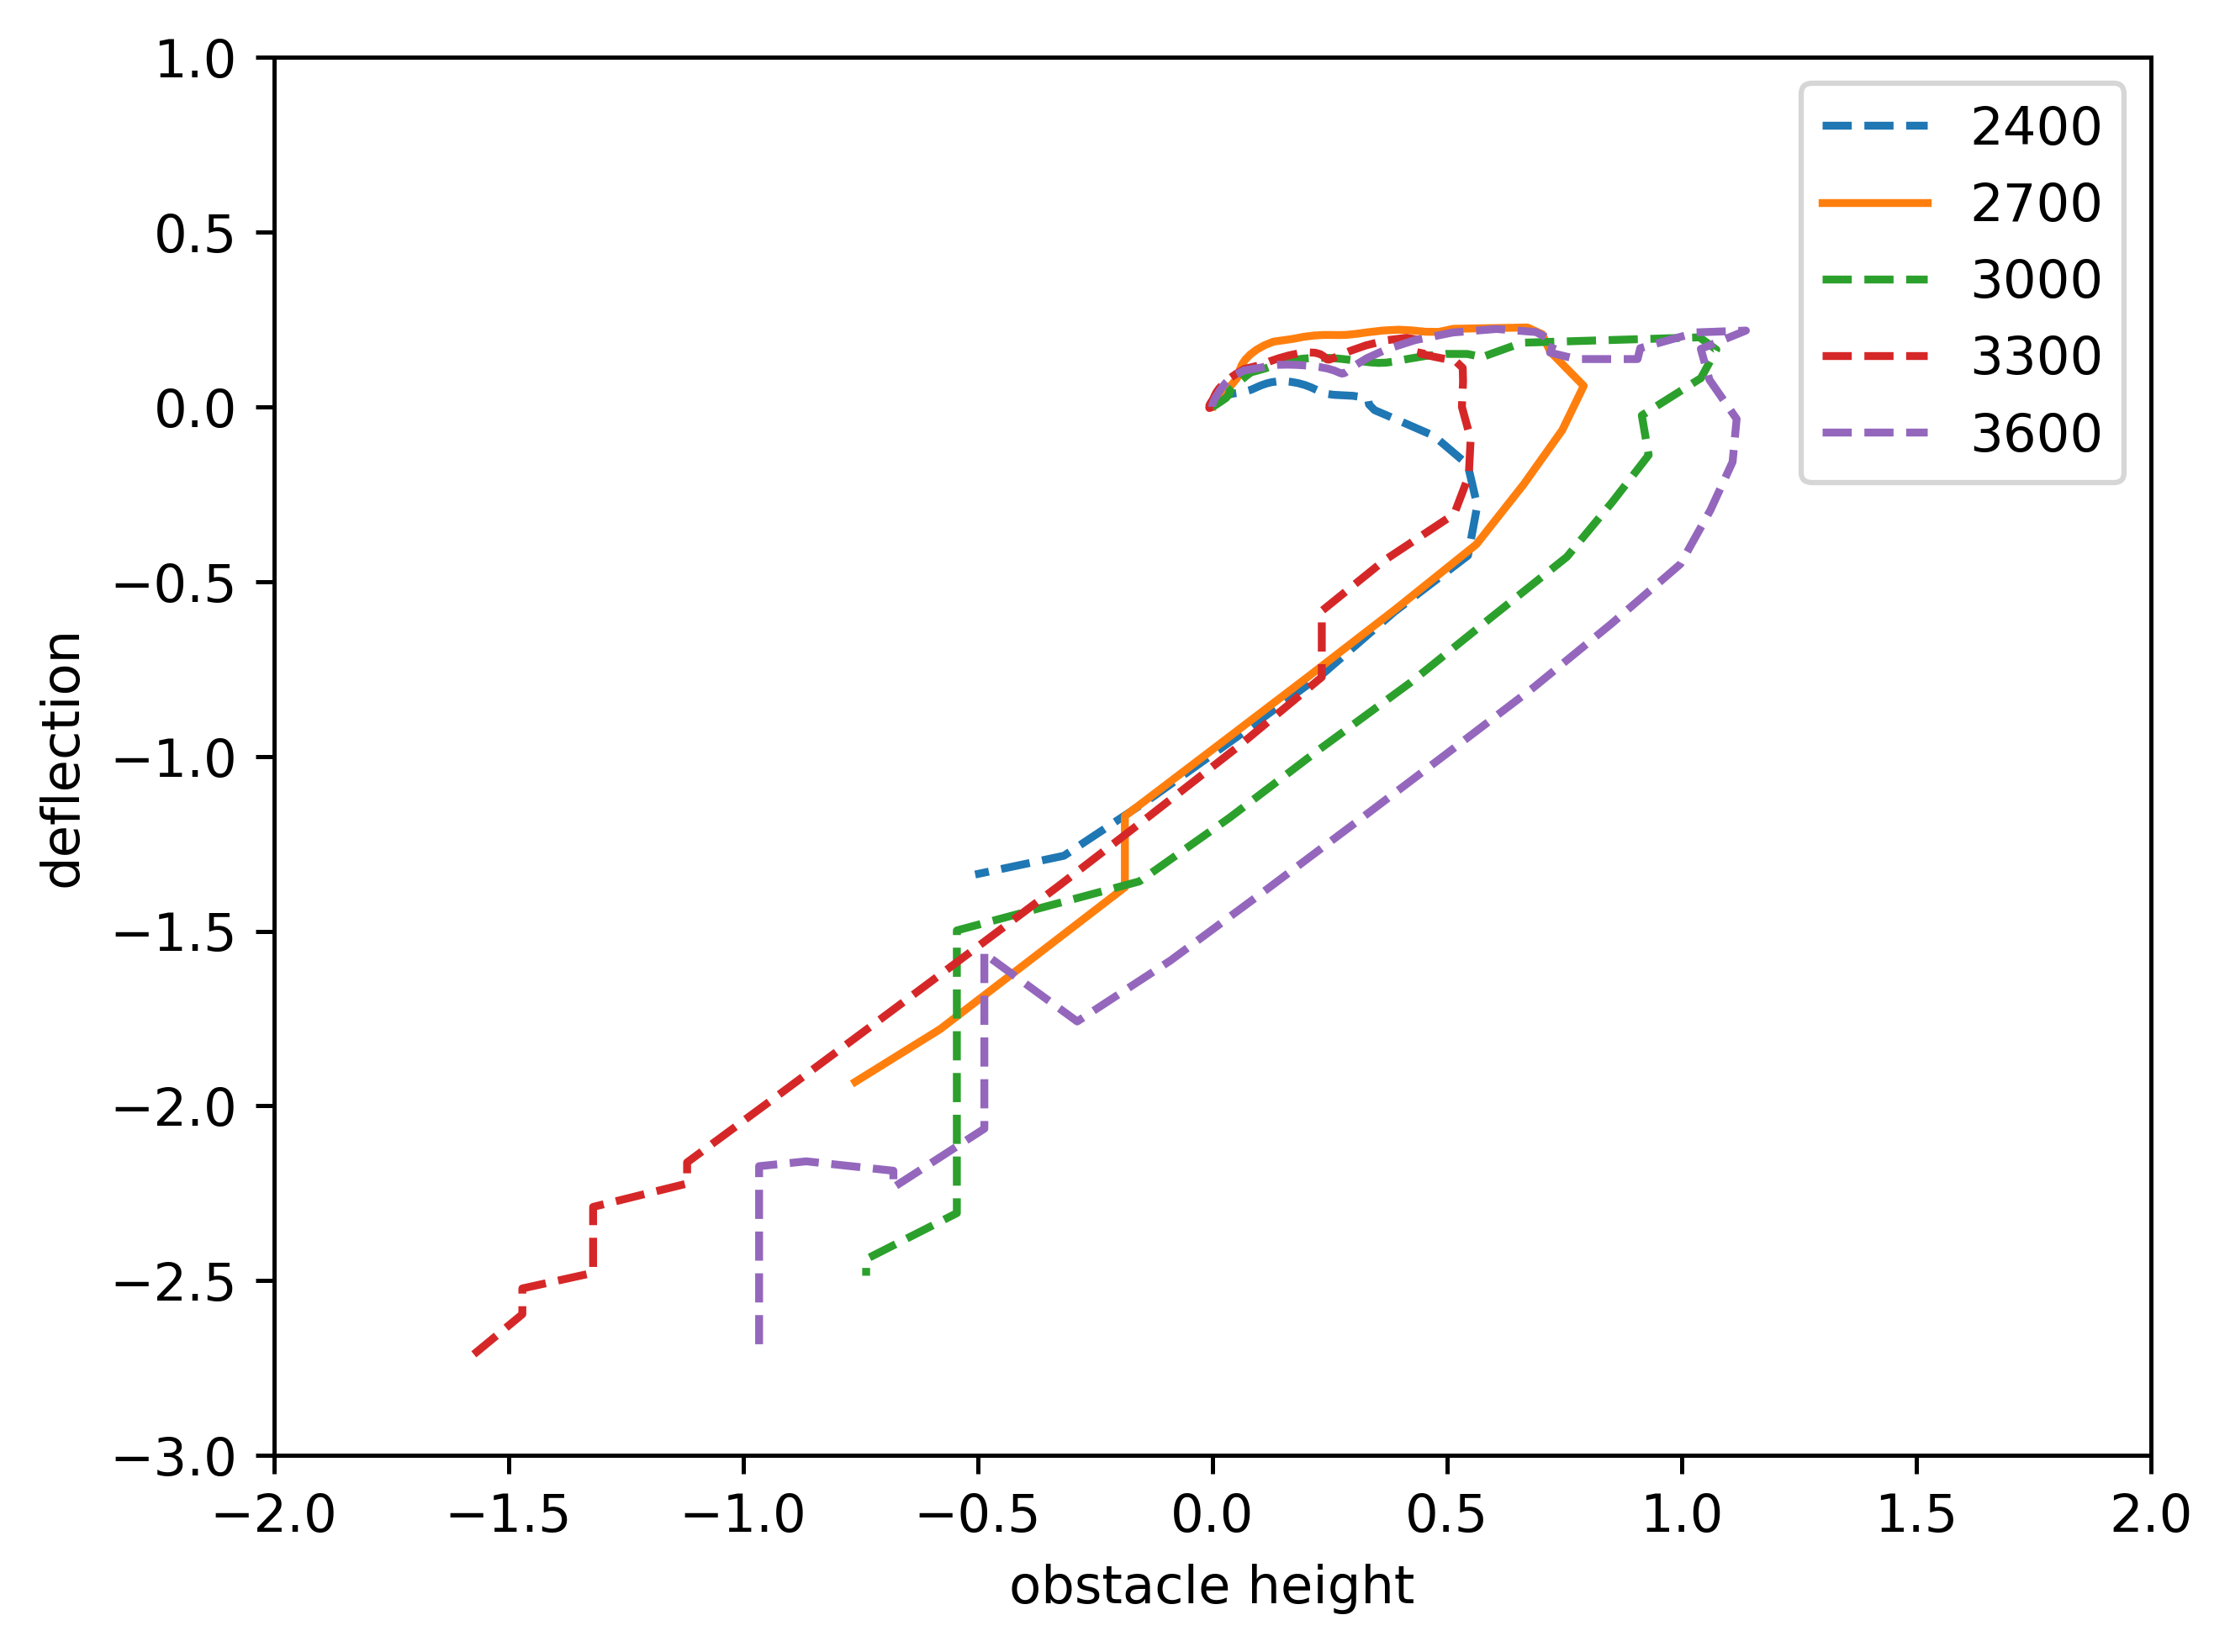

In [30]:
for snap, data in deflections.items():
    if snap == 2700:
        plt.plot(data[1], data[0], label=snap)
    else:
        plt.plot(data[1], data[0], '--', label=snap)
plt.legend()
plt.xlim([-2, 2])
plt.ylim([-3, 1])
plt.xlabel('obstacle height')
plt.ylabel('deflection')

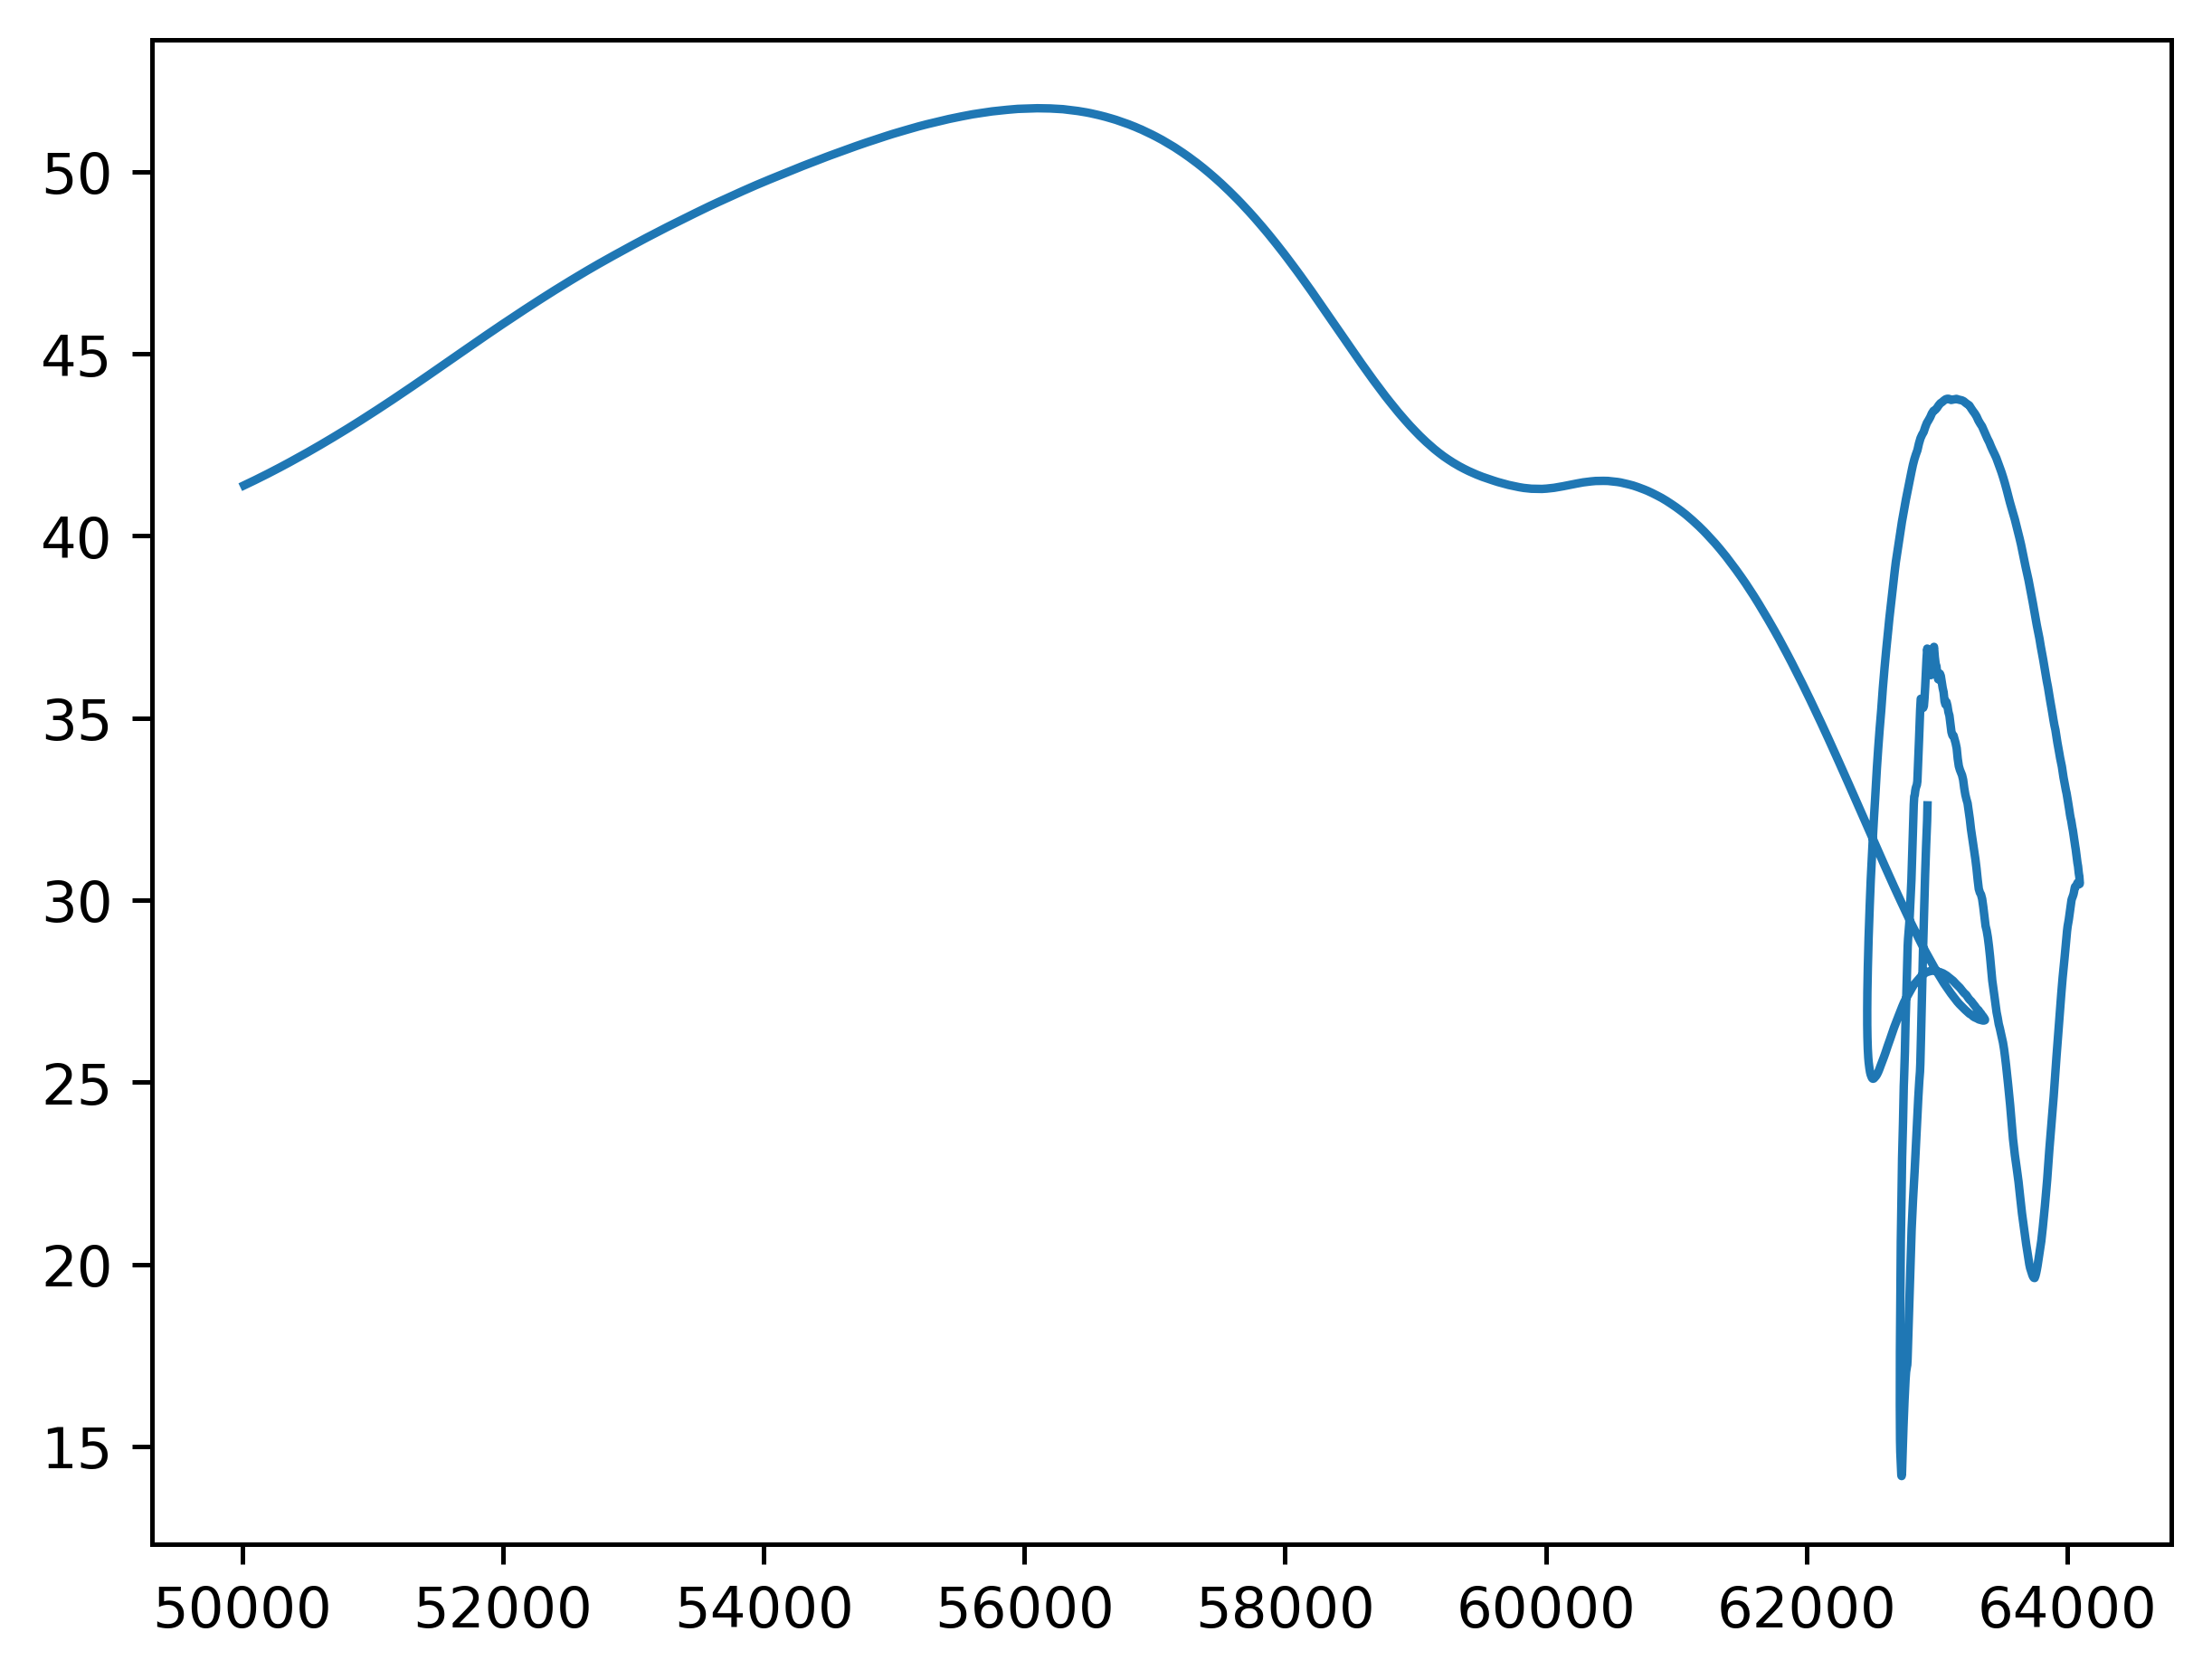

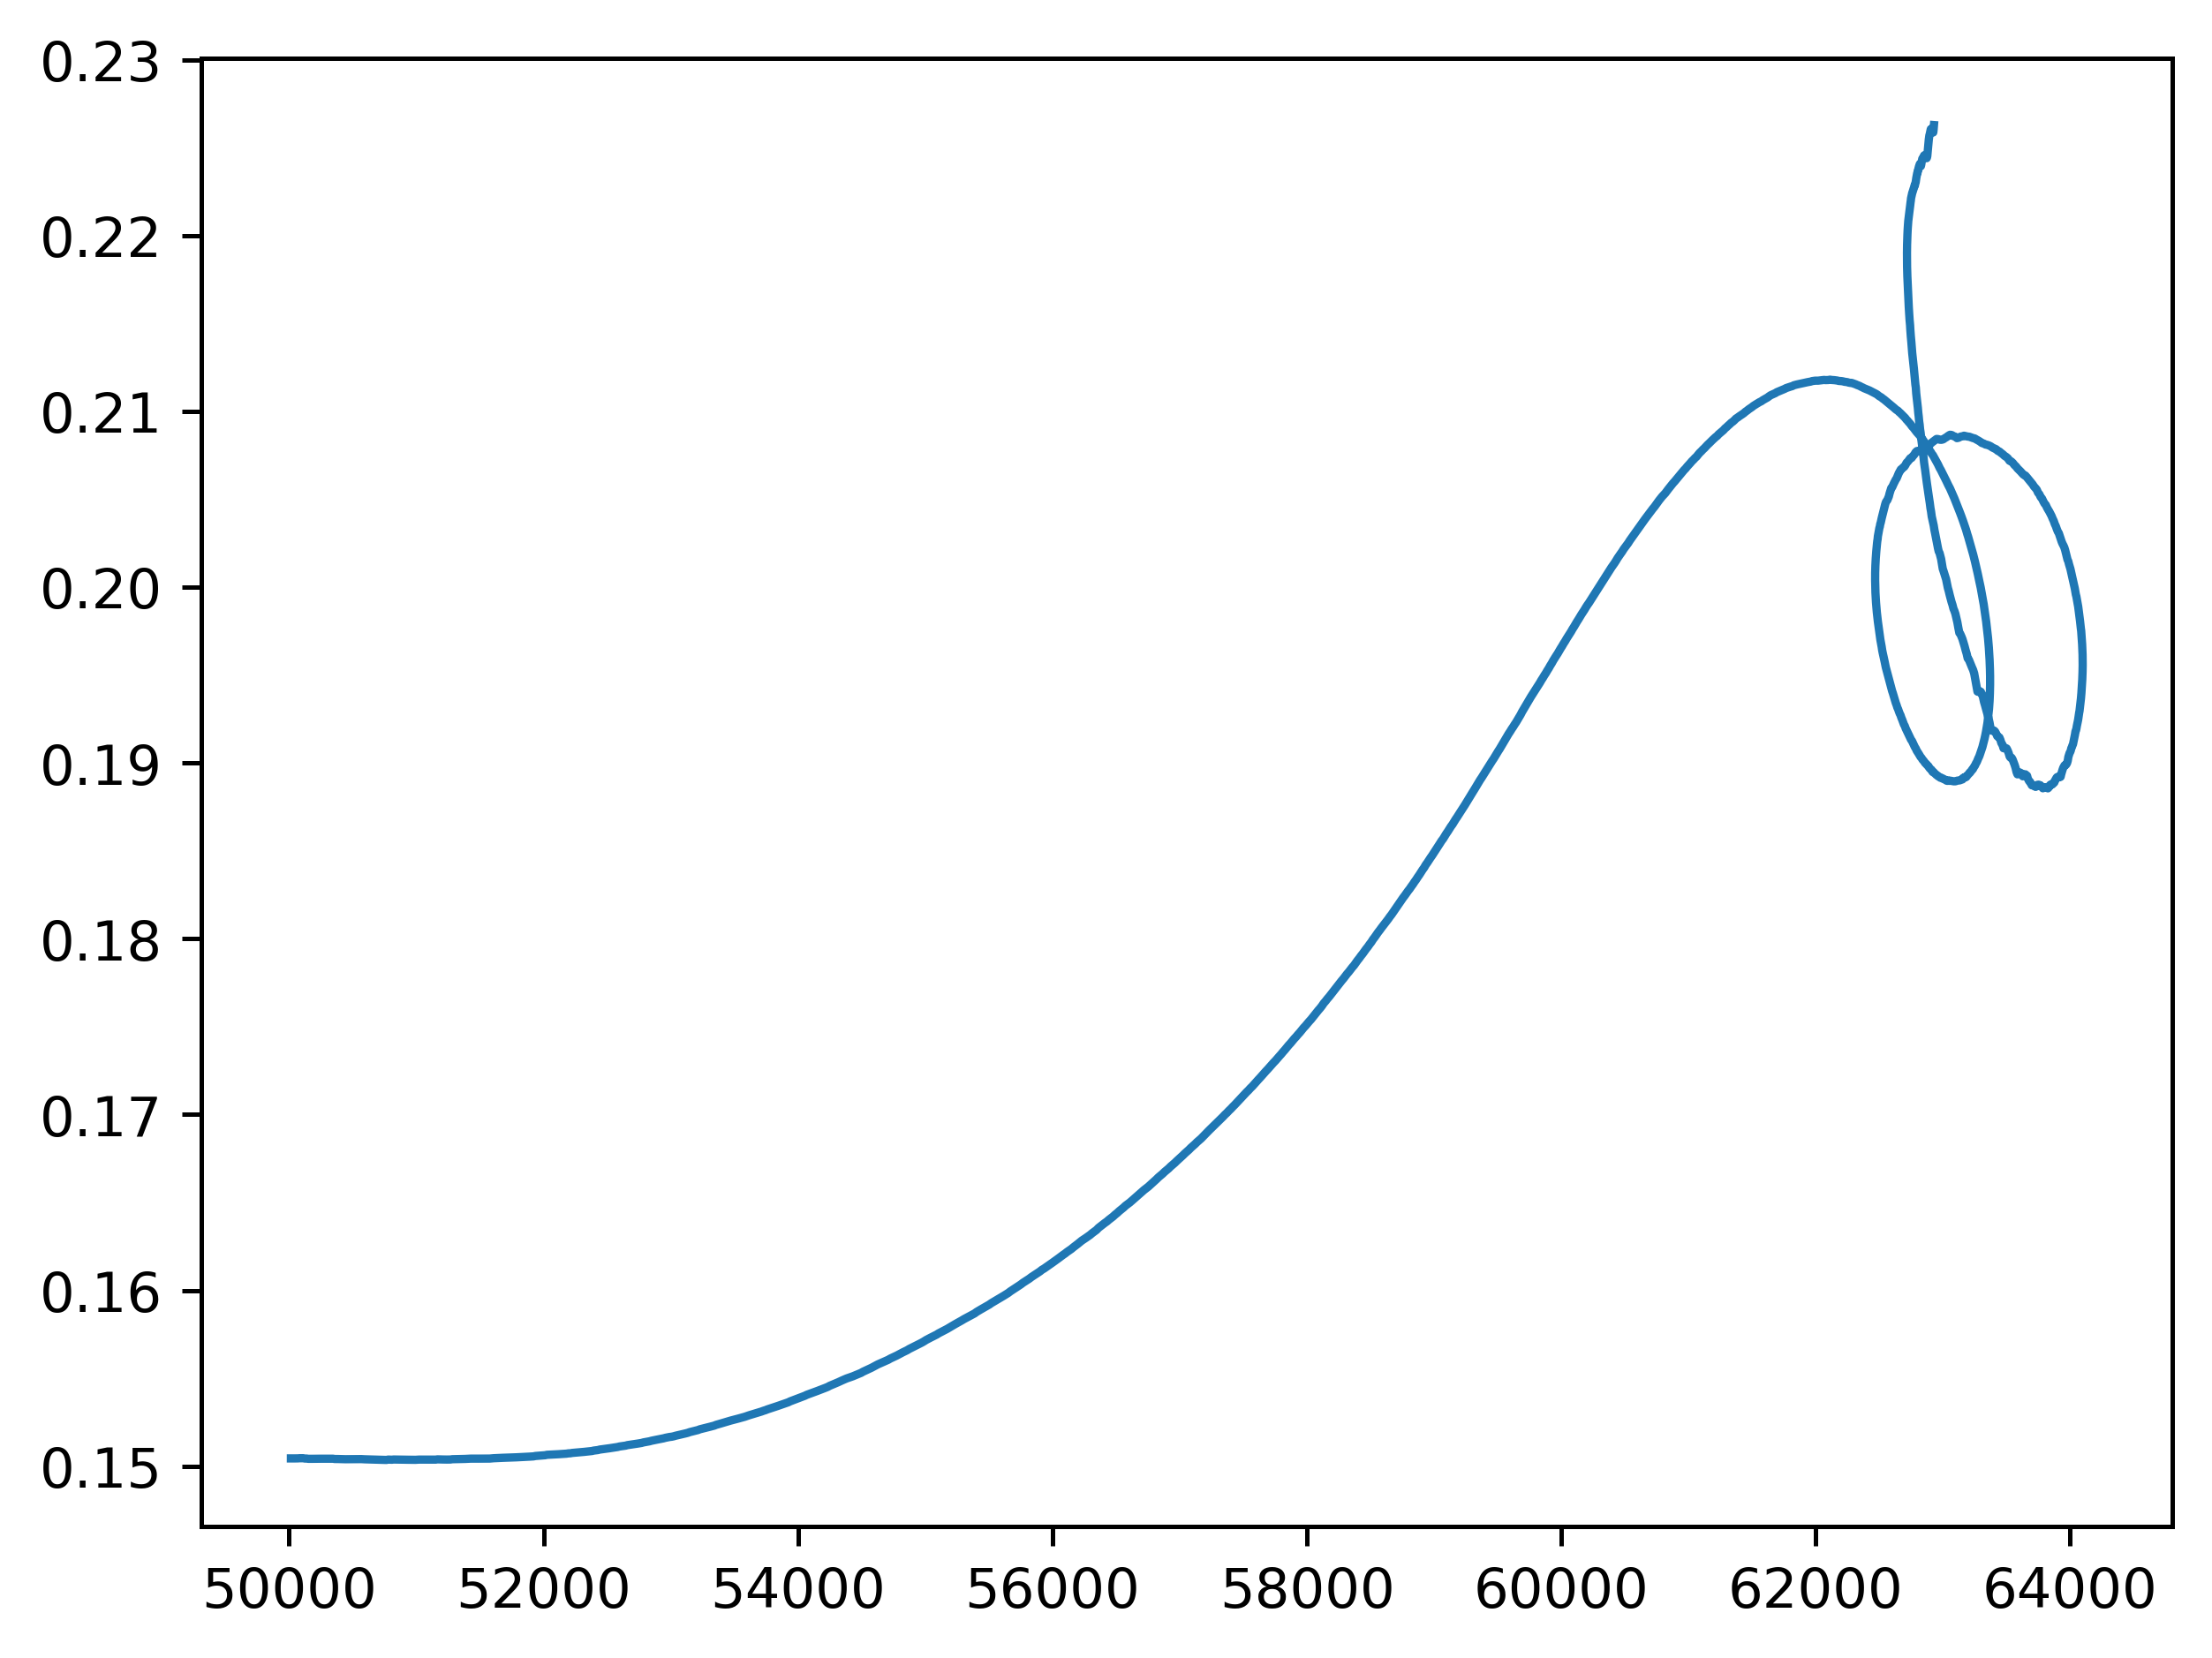

scorer parameter: 0.0006667936366463018


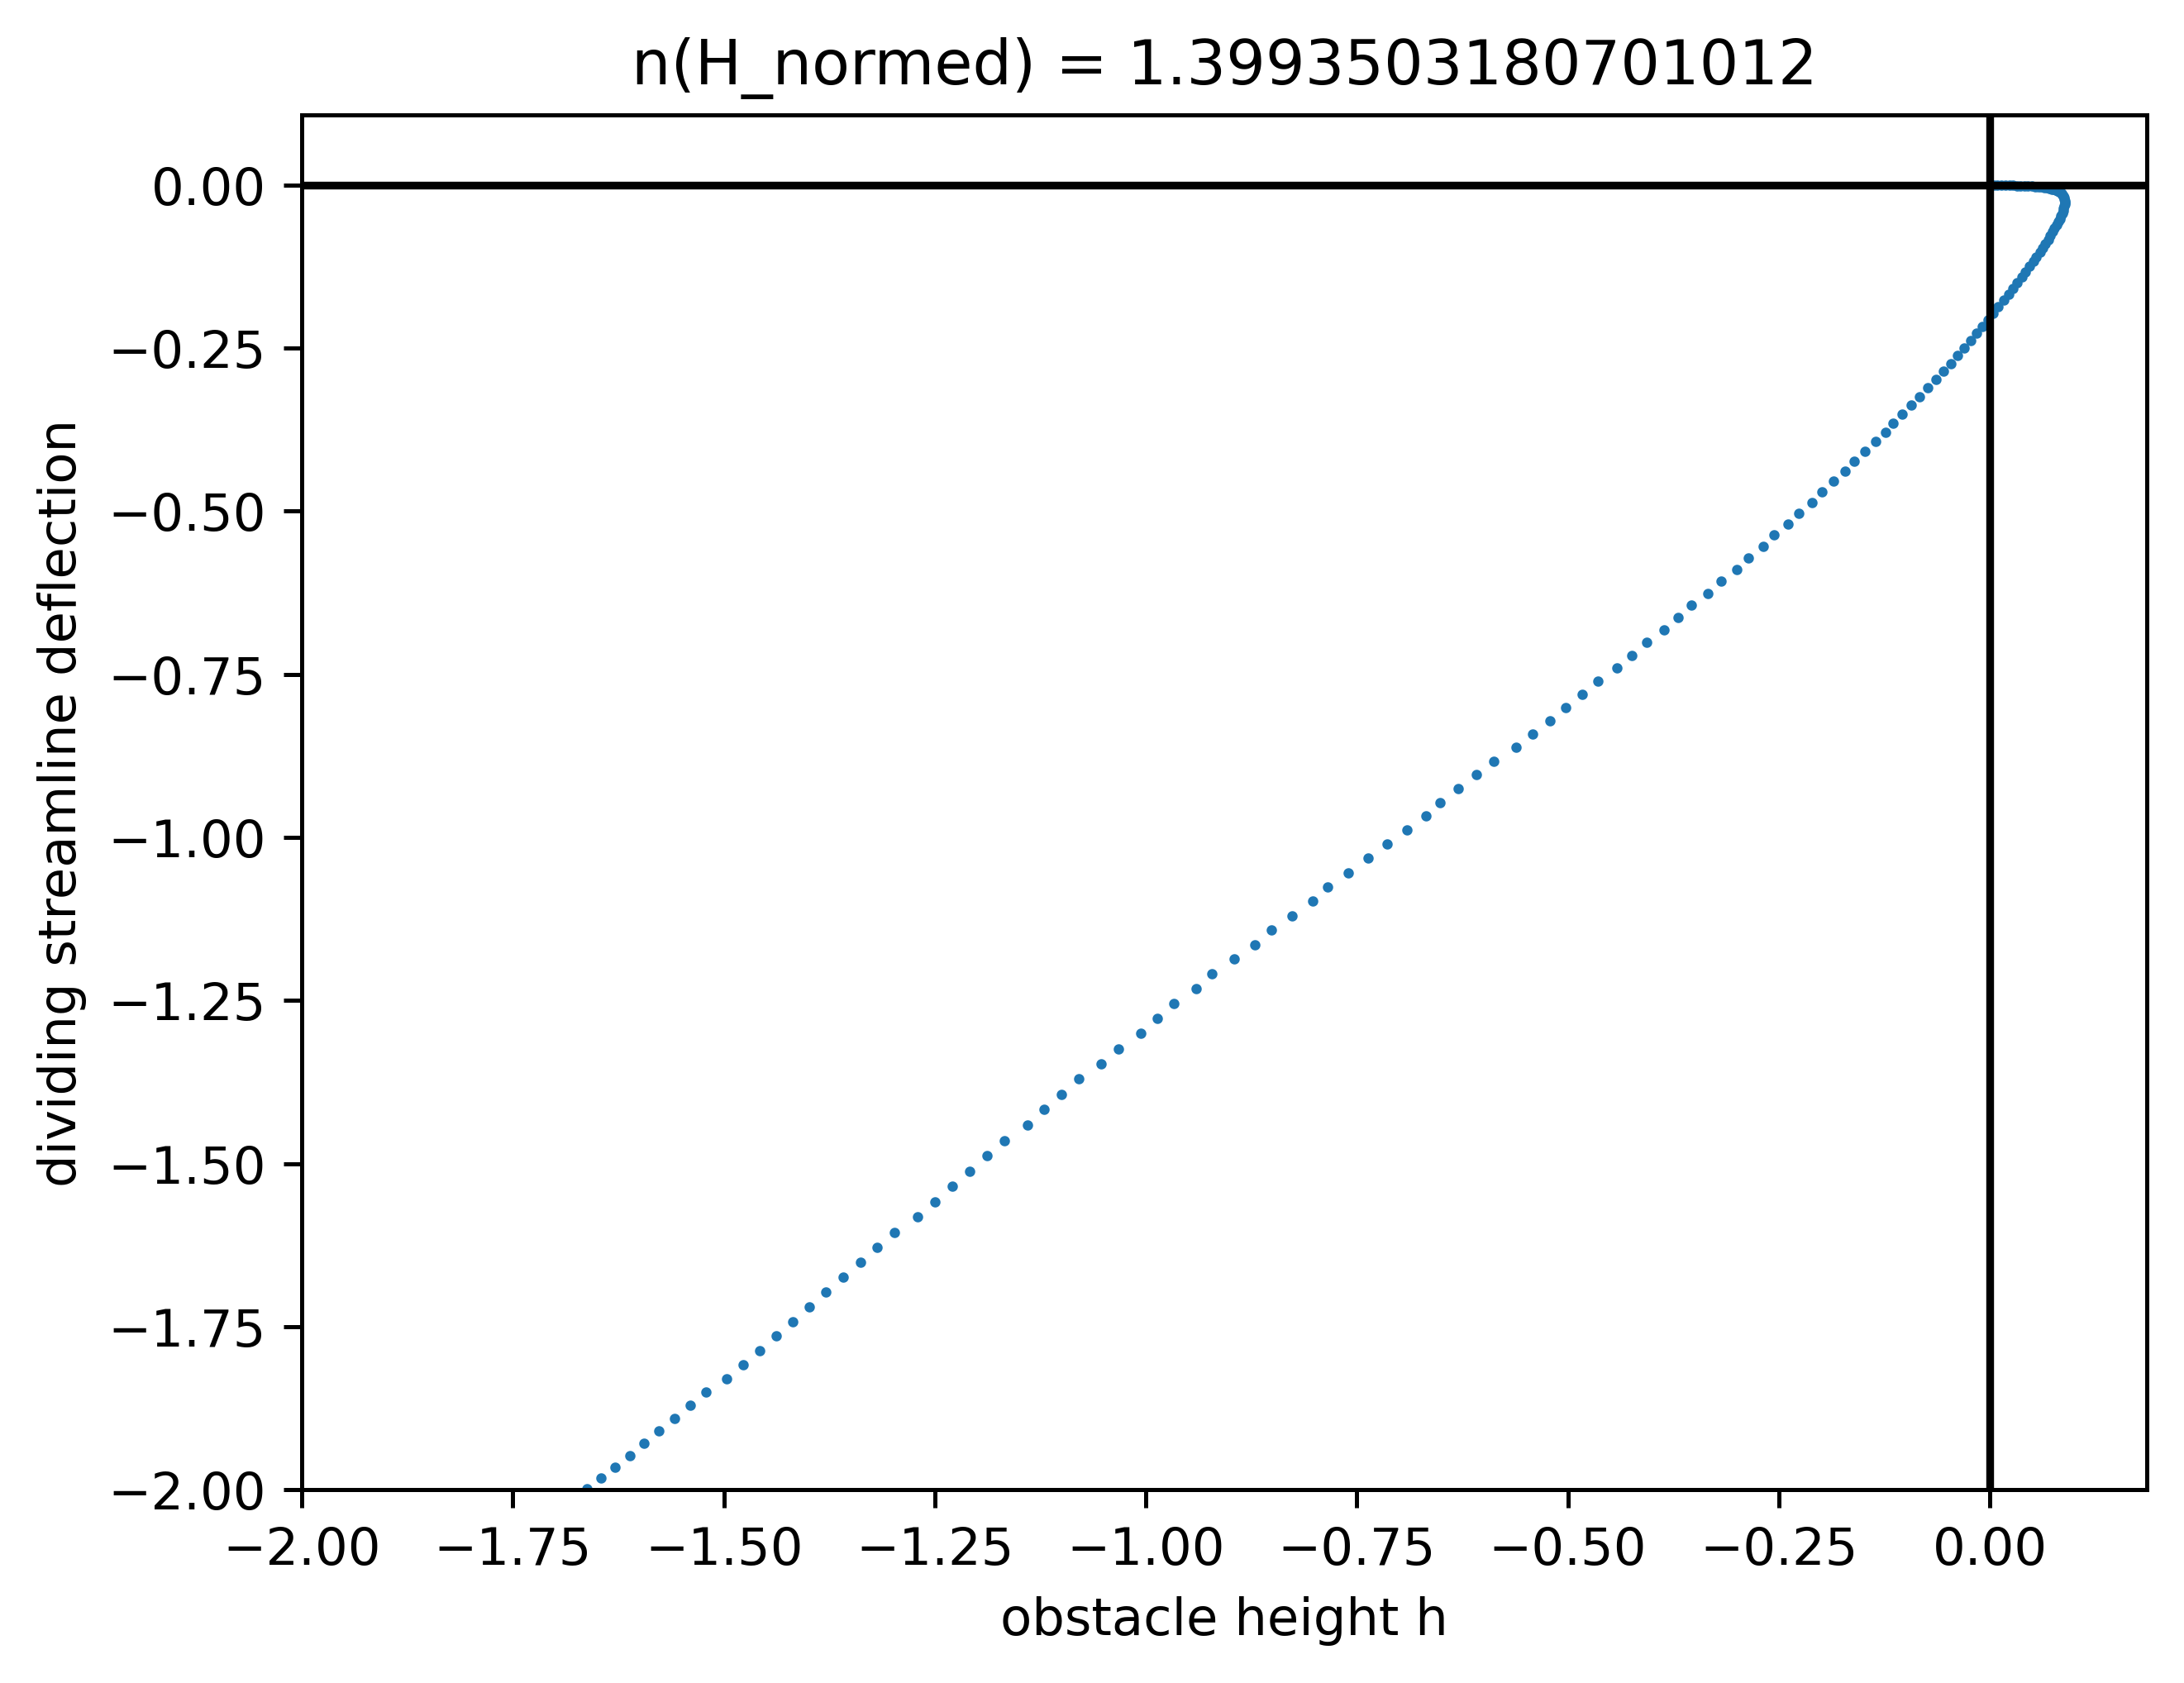

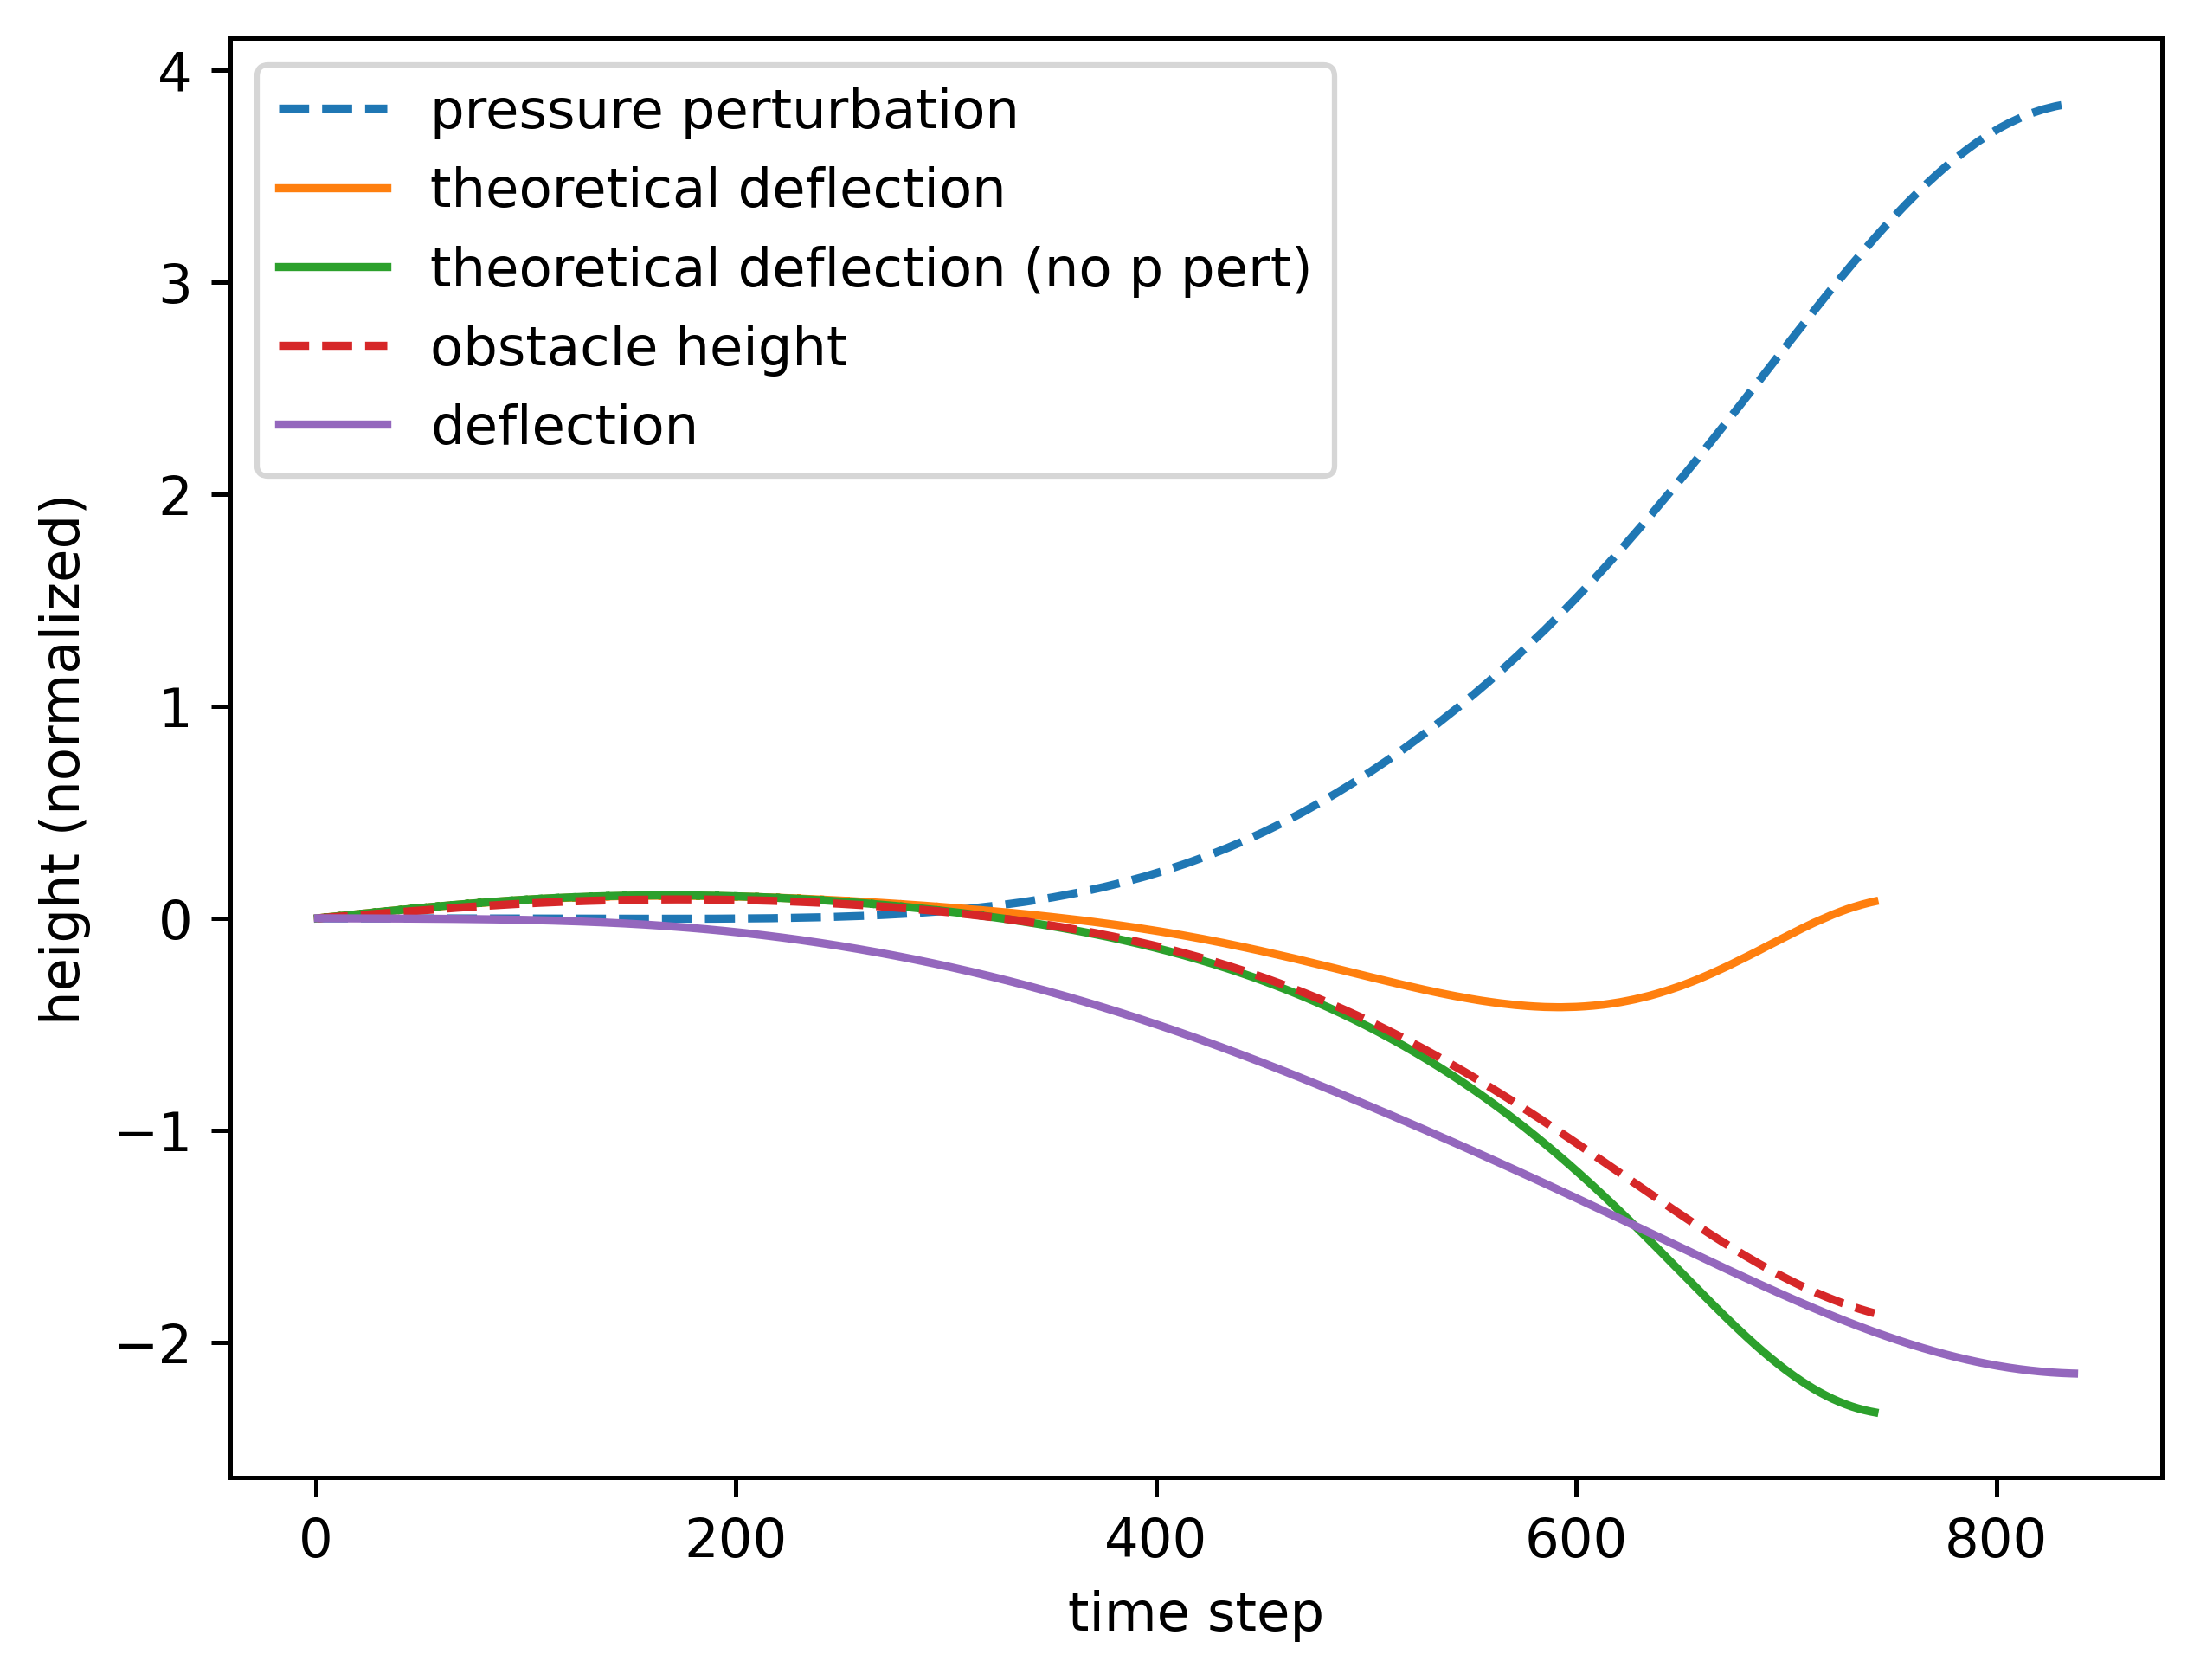

NameError: name 'jump_parcels' is not defined

NameError: name 'jump_parcels' is not defined

In [47]:
%run ./parcel_paths_to_theory.ipynb

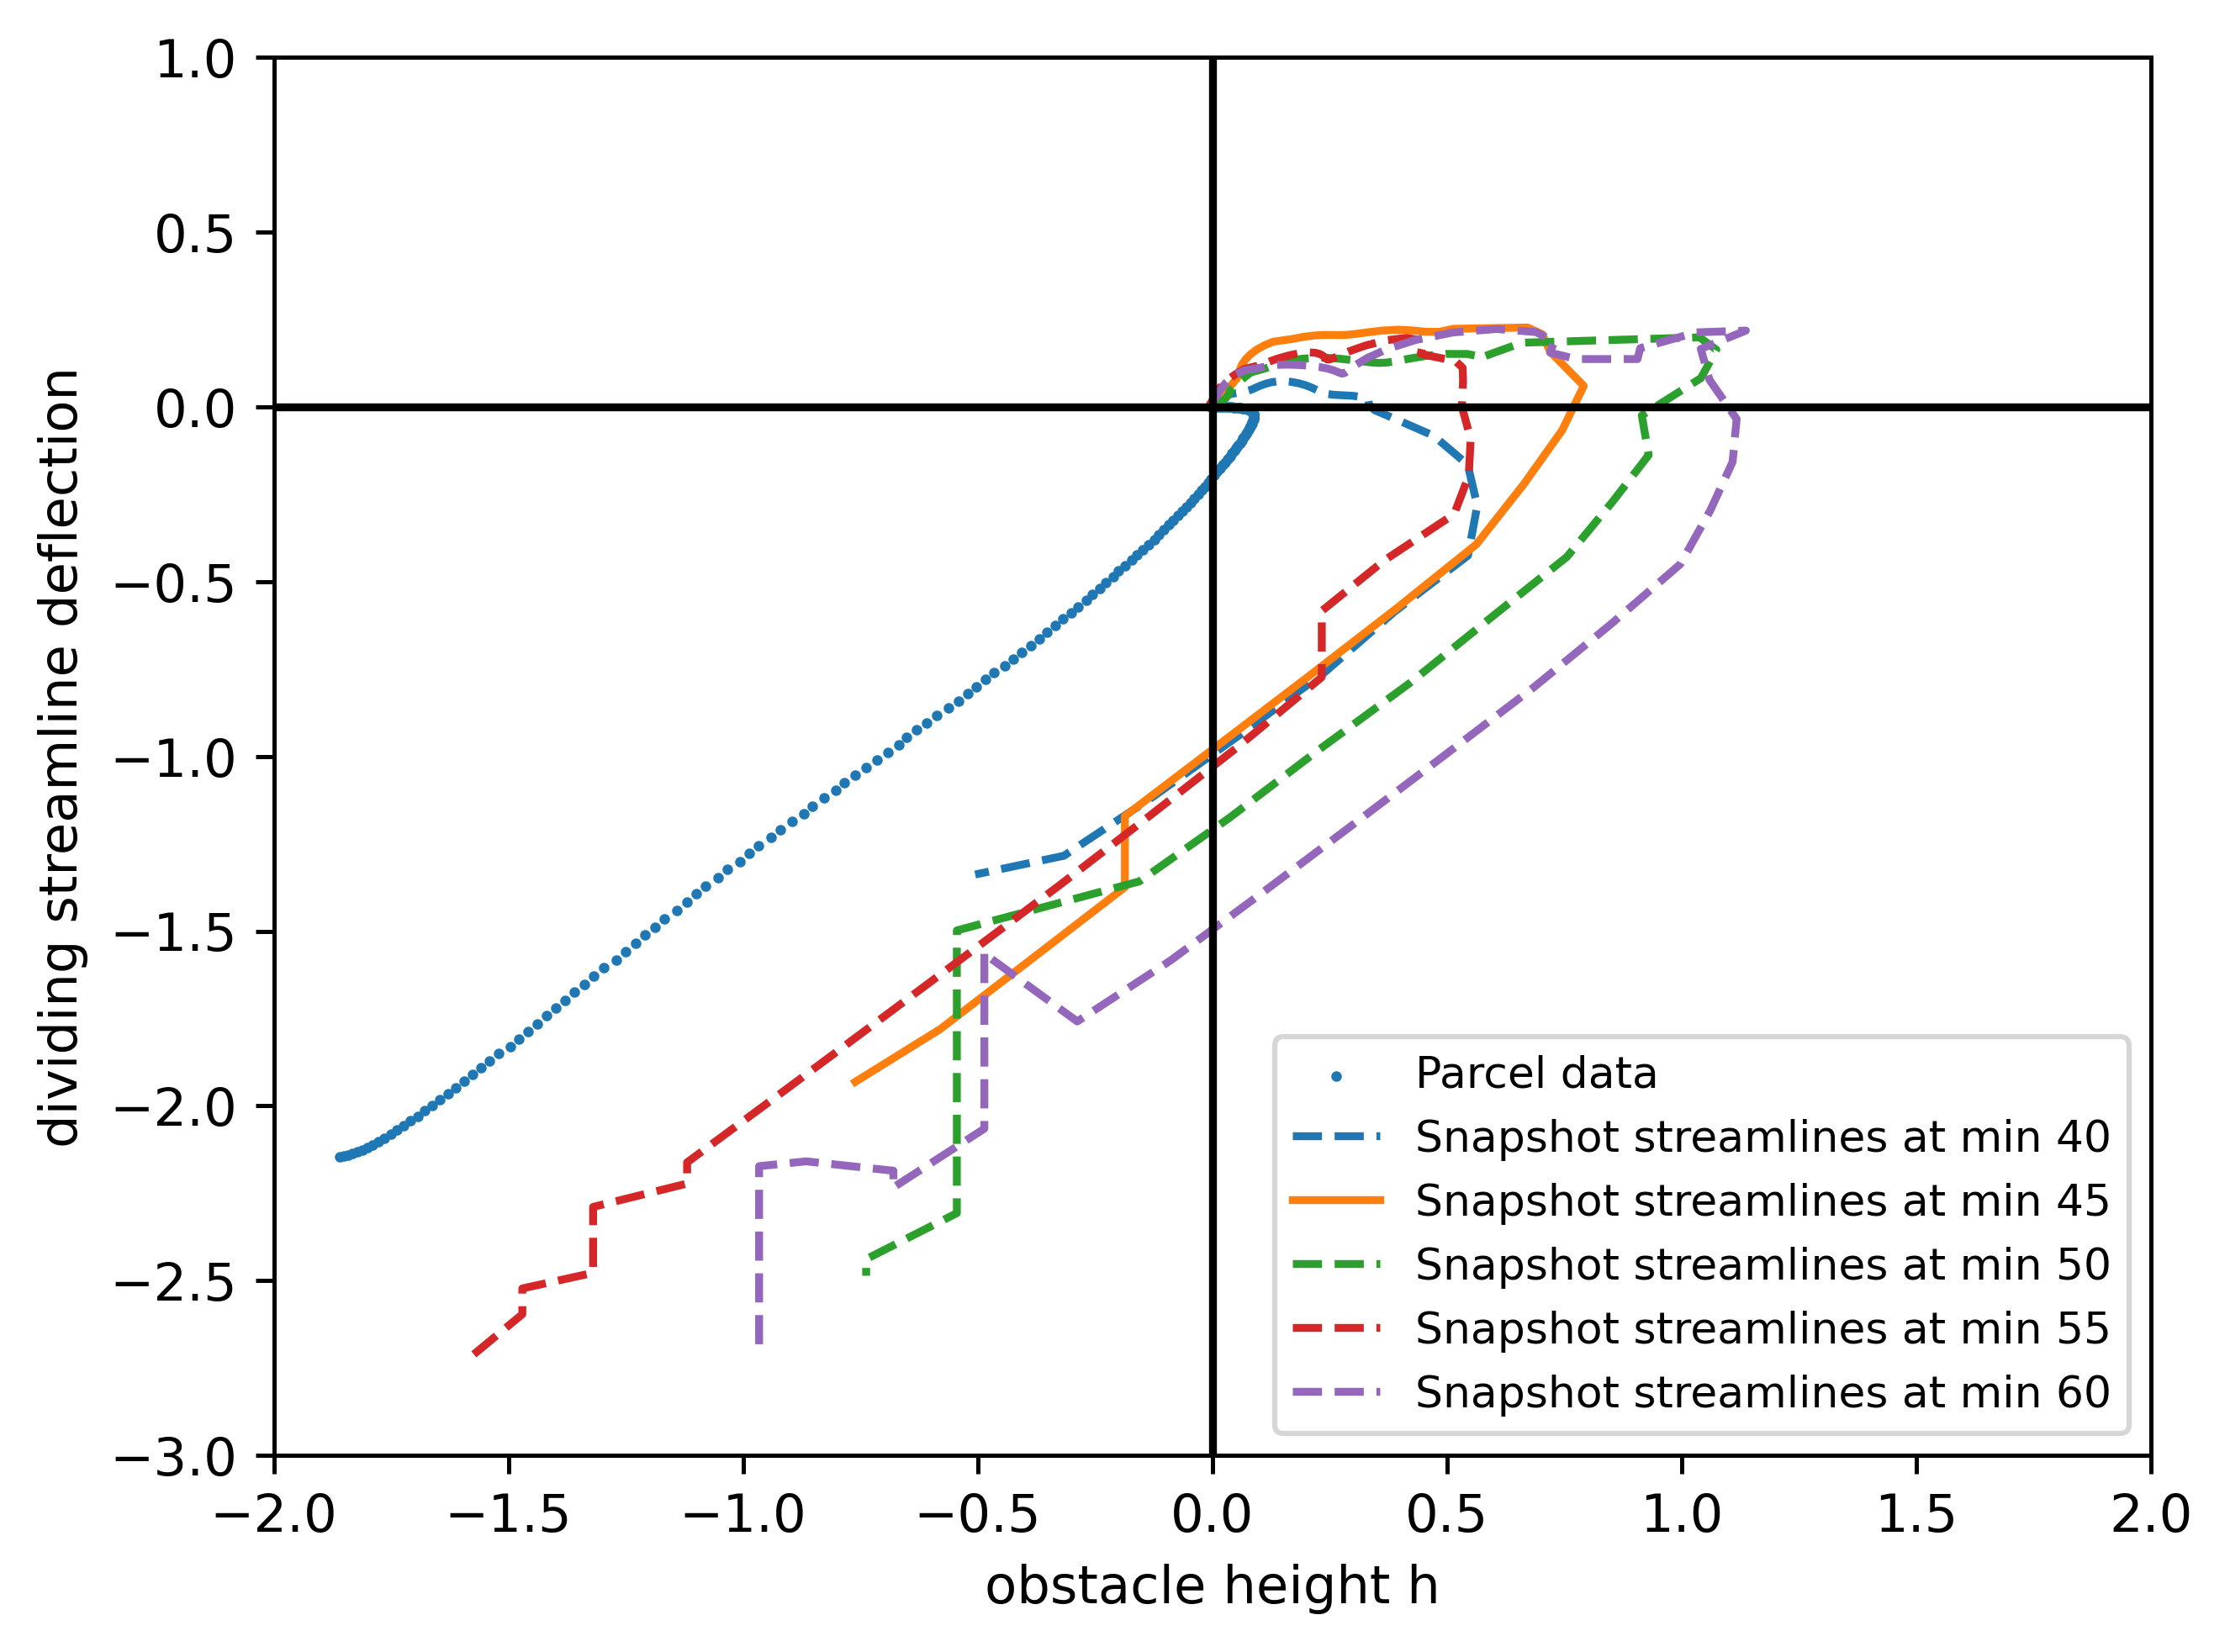

In [43]:
plt.scatter(h[::5], d[::5], s=1, label='Parcel data')

for snap, data in deflections.items():
    if snap == 2700:
        plt.plot(data[1], data[0], label=f'Snapshot streamlines at min {int(snap/60)}')
    else:
        plt.plot(data[1], data[0], '--', label=f'Snapshot streamlines at min {int(snap/60)}')

plt.xlabel('obstacle height')
plt.ylabel('deflection')

plt.axvline(0, color='k')
plt.axhline(0, color='k')
plt.legend(fontsize='small')
plt.xlabel('obstacle height h')
plt.ylabel('dividing streamline deflection')
# plt.title(f'n(H_normed) = 1.4')
plt.xlim([-2, 2])
plt.ylim([-3, 1])
plt.savefig('final_figures/Smith_fig_parcel_and_streamlines.jpeg')

In [54]:
(h/cos_term).shape

(1233,)

In [56]:
cos_term.shape

(969,)

In [ ]:
X = t.x_data.loc[x_ind, x_parcel]

# plt.plot(p_pert, '--', label='pressure perturbation')
# plt.plot(h / cos_term + p_pert * (np.sqrt(cos_term**(-2) - 1)), label='theoretical deflection with p pert')
plt.plot(h / cos_term, label='theoretical deflection')
plt.plot(h, '--', label='obstacle height')
plt.plot(d, label='deflection')
# plt.plot(cos_term, '--', label='cos_term')
plt.legend()
plt.xlabel('x')
plt.ylabel('height (normalized)')
plt.savefig('final_figures/Smith_fig_on_x_parcel.jpeg')